In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import sys

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append('./../src/')
from manuscript import sankey_side_by_side as sankey
from manuscript import clustering, datasets, inout, export

pd.options.display.max_columns = 200
mpl.rcParams["figure.figsize"] = (10, 8)
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["font.family"] = "Arial"

import IPython.display
IPython.display.display(IPython.display.HTML("<style>.container { width:90% !important; }</style>"))

fonts = inout.get_resource_path('fonts')
for f in os.listdir(fonts):
    if f.endswith(".ttf"):
        mpl.font_manager.fontManager.addfont(f"{fonts}/{f}")

In [4]:
user = 'CAG'     # defines top hierarchy of output folder
outfolder = '04_clustering_spider'    # name of notebook

In [5]:
def dump_figure(name):
    export.image(
        user,
        f'{outfolder}/{name}',
    )

In [6]:
def dump_table(df, name):
    export.full_frame(
        user, 
        f'{outfolder}/{name}', 
        df, 
        index=True,
        date=True
    )

# Get Data, as in reference

In [7]:
data = pd.read_csv(
    inout.get_material_path('general/05_join_clusters_umap/05_data_umap_clusters_221104_1154.csv.gz'), 
    index_col=0)

In [8]:
data_columns = clustering.get_reference_data_columns()
data_mtx_orig = data[data_columns].copy()

In [9]:
cutoff_groups_on_orig = clustering.identify_related_features(data_mtx_orig)
data_mtx_as_pct = data_mtx_orig.rank(axis=0, pct=True)
data_dist_col = clustering.get_distances(
    data_mtx_as_pct.transpose(), approach='nan_euclidean')   
col_tree = clustering.get_tree(data_dist_col, approach='ward')
threshold_for_relatedness = 0.7
cutoff_groups = cutoff_groups_on_orig[threshold_for_relatedness]

data_mtx = data_mtx_orig.copy()
data_mtx = data_mtx.rank(axis=0, pct=True)

data_mtx_for_similarity = data_mtx.copy()
data_mtx_for_similarity = clustering.reweight_related_features(
    data_mtx_for_similarity, 
    approach='mean_rank', 
    groups=cutoff_groups)
corr_mtx = data_mtx_for_similarity.transpose().corr("pearson")
data_dist = clustering.get_distances(corr_mtx, approach='euclidean')   
tree = clustering.get_tree(df_dist=data_dist, approach='ward')
out, assignments = clustering.table_with_assignments(
    tree=tree,
    labels=data.index
)
sign_mortality_similarity = clustering.get_sign_mortalities(
    df_assigned_clusters=out,
    df_with_mortality=data
)
sign_mortality_similarity.loc[:, 'approach'] = 'similarity'
approaches = {
    'Similarity' : {
        'feature_matrix': data_mtx,   # data_mtx_orig.rank(axis=0, pct=True),
        'data_dist':data_dist,
        'tree':tree,
        'assignments_table':out,
        'assignments':assignments
    }
}

# reproduce quilt 

Text(0, 1.1, 'row max.')

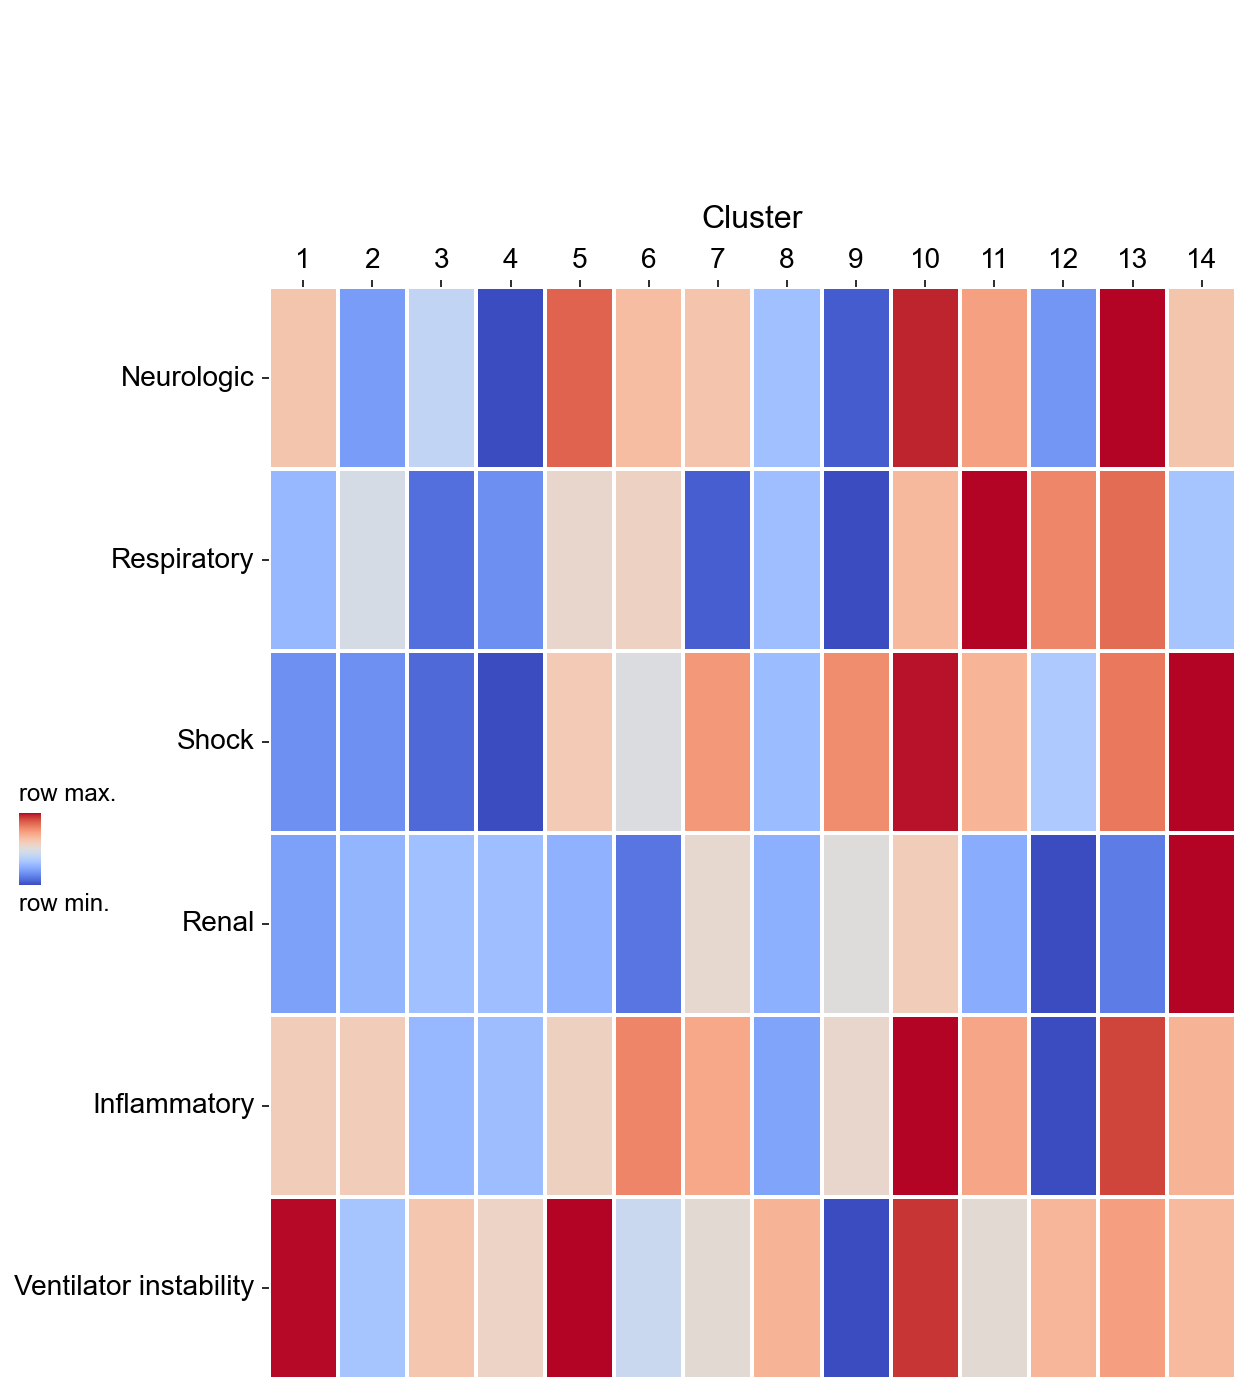

In [10]:
FEATURE_GROUPS = [
    ["Neurologic", '-RASS_score', '-GCS_eye_opening', '-GCS_motor_response', '-GCS_verbal_response'],
    ["Respiratory", 'Intubation_flag', '-PaO2FIO2_ratio', '-ABG_PaO2', 'FiO2', 'PEEP', 
     '-Oxygen_saturation', 'Plateau_Pressure', '-Lung_Compliance', 'ECMO_flag', 'Respiratory_rate'],
    ["Shock", 'Norepinephrine_flag', 'Norepinephrine_rate', '-Mean_arterial_pressure',
    '-Systolic_blood_pressure', '-Diastolic_blood_pressure', 'Lactic_acid', '-Hemoglobin', 
    '-ABG_pH', 'ABG_PaCO2', 'Heart_rate', '-Bicarbonate'],
    ["Renal", 'CRRT_flag', 'Hemodialysis_flag', 'Creatinine', '-Urine_output'],
    ["Inflammatory", 'WBC_count', 'Neutrophils', 'Platelets', 'Procalcitonin', 'CRP',
    'D_dimer', 'LDH', 'Ferritin', 'Bilirubin',  '-Albumin', '-Lymphocytes', 'Temperature'],
    ["Ventilator instability", 'Respiratory_rate_changes', 'PEEP_changes', 'FiO2_changes']
]

df = pd.DataFrame(0, index=data.index, columns=[x[0] for x in FEATURE_GROUPS])
for group in FEATURE_GROUPS:
    for feature in group[1:]:
        sign = 1
        if feature.startswith("-"):
            sign = -1
            feature = feature[1:]
        idx = ~data_mtx[feature].isna()
        if feature in ("ECMO_flag", 'Intubation_flag', 'Hemodialysis_flag', 'CRRT_flag'):
            df.loc[idx, group[0]] += data.loc[idx, feature] * sign
        else:
            df.loc[idx, group[0]] += data_mtx.loc[idx, feature] * sign
        if f"{group[0]}_cnt" not in df.columns:
            df[f"{group[0]}_cnt"] = 0
        df.loc[idx, f"{group[0]}_cnt"] += 1

quilt_df = pd.DataFrame(0, index=[x[0] for x in FEATURE_GROUPS], columns=sorted(data.clusters.unique()))

for group in FEATURE_GROUPS:
    for c in quilt_df.columns:
        idx = data.index[data.clusters.eq(c)]
        quilt_df.loc[group[0], c] = df.loc[idx, group[0]].sum() / df.loc[idx, f"{group[0]}_cnt"].sum()
cg = sns.clustermap(
    quilt_df,
    col_cluster=False,
    row_cluster=False,
    standard_scale="row",
    cmap="coolwarm",
    cbar_pos=(0.01, 0.38, 0.015, 0.05),
    cbar_kws={"ticks": []},
    vmin=0,
    vmax=1,
    linewidths=2,
)
cg.ax_heatmap.tick_params(
    bottom=False, 
    labelbottom=False, 
    top=True, 
    labeltop=True, 
    left=True,
    labelleft=True,
    right=False,
    labelright=False,
    labelsize=14
)
cg.ax_heatmap.set_xlabel("Cluster", size=16, labelpad=10)
cg.ax_heatmap.xaxis.set_label_position("top")
cg.cax.annotate("row min.", (0, -0.1), va="top", annotation_clip=False, fontsize=12)
cg.cax.annotate("row max.", (0, 1.1), va="bottom", annotation_clip=False, fontsize=12)

In [11]:
quilt_df

1         2         3         4         5   \
Neurologic             -0.449033 -0.682228 -0.567699 -0.786448 -0.316136   
Respiratory             0.090300  0.166092  0.010261  0.041863  0.196737   
Shock                  -0.275733 -0.274720 -0.312306 -0.339604 -0.099129   
Renal                  -0.006720  0.019230  0.034583  0.031293  0.014819   
Inflammatory            0.303111  0.303170  0.251779  0.254452  0.299927   
Ventilator instability  0.559290  0.442563  0.494016  0.484498  0.560453   

                              6         7         8         9         10  \
Neurologic             -0.433757 -0.448338 -0.620659 -0.766219 -0.261132   
Respiratory             0.207294 -0.005971  0.098498 -0.021995  0.244006   
Shock                  -0.144102 -0.040640 -0.223965 -0.029317  0.053732   
Renal                  -0.053504  0.131744  0.012809  0.118659  0.156459   
Inflammatory            0.335533  0.322088  0.241782  0.294924  0.368110   
Ventilator instability  0.461750  0.478096  0.505186  0.386392  0.551371   

                              11        12        13        14  
Neurologic             -0.391119 -0.689565 -0.245685 -0.448872  
Respiratory             0.378633  0.295739  0.318835  0.107327  
Shock                  -0.069226 -0.203973 -0.010331  0.058435  
Renal                   0.006969 -0.092576 -0.046498  0.324138  
Inflammatory            0.323313  0.206737  0.355825  0.316784  
Ventilator instability  0.477978  0.503507  0.514815  0.500783

In [12]:
dump_table(quilt_df, 'quilt_df.csv')

# normalize 

In [7]:
quilt_df = pd.read_csv(
    inout.get_material_path('CAG/04_clustering_spider/quilt_df_221205_1404.csv'), 
    index_col=0)

In [16]:
quilt_df

1         2         3         4         5  \
Neurologic             -0.449033 -0.682228 -0.567699 -0.786448 -0.316136   
Respiratory             0.090300  0.166092  0.010261  0.041863  0.196737   
Shock                  -0.275733 -0.274720 -0.312306 -0.339604 -0.099129   
Renal                  -0.006720  0.019230  0.034583  0.031293  0.014819   
Inflammatory            0.303111  0.303170  0.251779  0.254452  0.299927   
Ventilator instability  0.559290  0.442563  0.494016  0.484498  0.560453   

                               6         7         8         9        10  \
Neurologic             -0.433757 -0.448338 -0.620659 -0.766219 -0.261132   
Respiratory             0.207294 -0.005971  0.098498 -0.021995  0.244006   
Shock                  -0.144102 -0.040640 -0.223965 -0.029317  0.053732   
Renal                  -0.053504  0.131744  0.012809  0.118659  0.156459   
Inflammatory            0.335533  0.322088  0.241782  0.294924  0.368110   
Ventilator instability  0.461750  0.478096  0.505186  0.386392  0.551371   

                              11        12        13        14  
Neurologic             -0.391119 -0.689565 -0.245685 -0.448872  
Respiratory             0.378633  0.295739  0.318835  0.107327  
Shock                  -0.069226 -0.203973 -0.010331  0.058435  
Renal                   0.006969 -0.092576 -0.046498  0.324138  
Inflammatory            0.323313  0.206737  0.355825  0.316784  
Ventilator instability  0.477978  0.503507  0.514815  0.500783

In [17]:
quiltdf2 = quilt_df.T

In [18]:
def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())
for col in quiltdf2.columns:
    quiltdf2[col] = min_max_scaling(quiltdf2[col])

In [19]:
quiltdf2=quiltdf2.reset_index().rename(columns={'index':'cluster'})

In [34]:
quiltdf2['cluster']=quiltdf2['cluster'].astype(int)

In [35]:
COVID_higher= [1, 2, 5, 6, 10, 11, 12, 13]

In [36]:
COVID_stat_higher= [1, 2, 5, 10, 11, 13]

In [37]:
quiltdf2['COVID_higher']=np.where(quiltdf2['cluster'].isin(COVID_higher),True,False)

In [67]:
quiltdf2['COVID_stat_higher']=np.where(quiltdf2['cluster'].isin(COVID_stat_higher),'Significant','Not significant')

In [68]:
quiltdf2

cluster  Neurologic  Respiratory     Shock     Renal  Inflammatory  \
0         1    0.623961     0.280297  0.160465  0.206030      0.597210   
1         2    0.192728     0.469480  0.163009  0.268305      0.597577   
2         3    0.404519     0.080514  0.068582  0.305147      0.279115   
3         4    0.000000     0.159394  0.000000  0.297252      0.295680   
4         5    0.869719     0.545973  0.604149  0.257720      0.577480   
5         6    0.652211     0.572323  0.491165  0.093763      0.798126   
6         7    0.625247     0.039998  0.751093  0.538306      0.714811   
7         8    0.306584     0.300761  0.290522  0.252896      0.217167   
8         9    0.037408     0.000000  0.779541  0.506906      0.546477   
9        10    0.971435     0.663961  0.988186  0.597616      1.000000   
10       11    0.731059     1.000000  0.679276  0.238880      0.722400   
11       12    0.179159     0.793091  0.340747  0.000000      0.000000   
12       13    1.000000     0.850739  0.827239  0.110575      0.923872   
13       14    0.624259     0.322798  1.000000  1.000000      0.681939   

    Ventilator instability  COVID_higher COVID_stat_higher  
0                 0.993319          True       Significant  
1                 0.322708          True       Significant  
2                 0.618315         False   Not significant  
3                 0.563630         False   Not significant  
4                 1.000000          True       Significant  
5                 0.432941          True   Not significant  
6                 0.526851         False   Not significant  
7                 0.682485         False   Not significant  
8                 0.000000         False   Not significant  
9                 0.947825          True       Significant  
10                0.526173          True       Significant  
11                0.672842          True   Not significant  
12                0.737806          True       Significant  
13                0.657188         False   Not significant

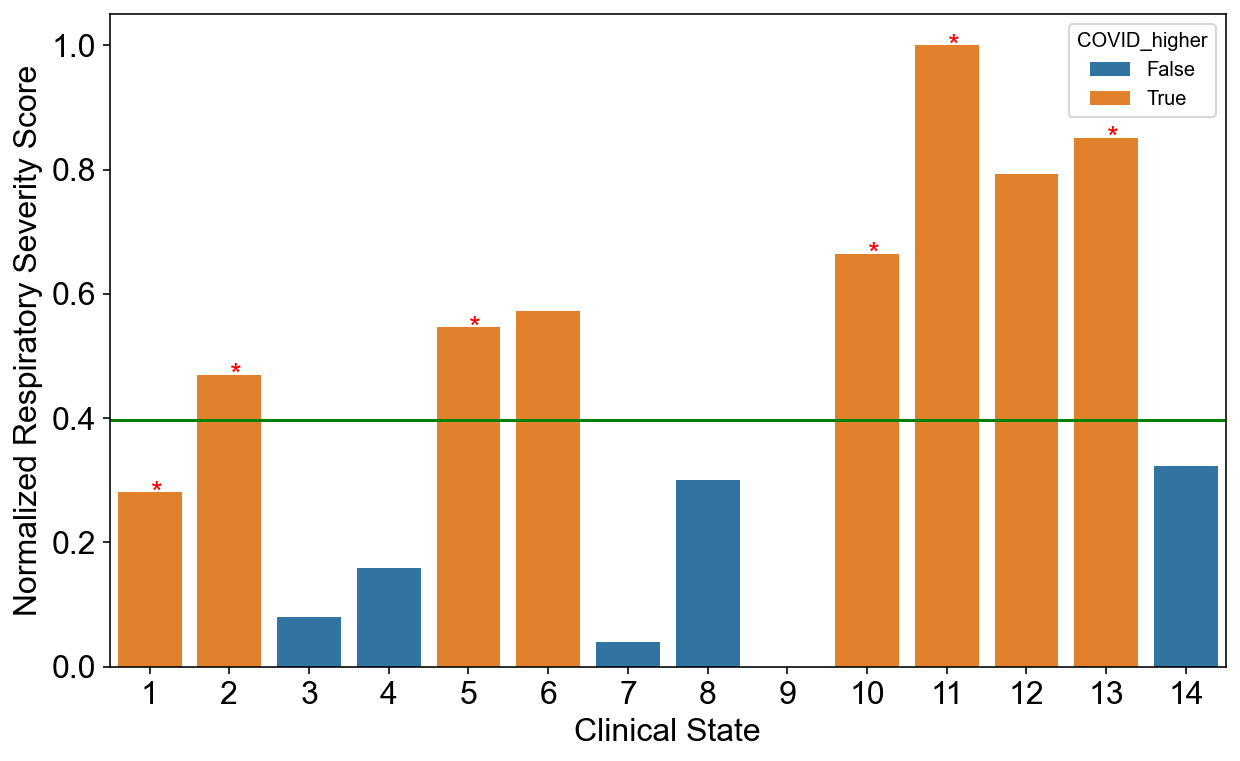

In [196]:
f,ax = plt.subplots(nrows=1,figsize=(10,6))

g=sns.barplot(data=quiltdf2, x='cluster', y='Respiratory', hue='COVID_higher',dodge=False)
#g=sns.stripplot(data=quiltdf2, x='cluster',y='Respiratory',hue='COVID_stat_higher', palette=COVID_stat_higher_palette,)
g.axhline(y = quiltdf2.Respiratory.median(), color = "green",)

for _, row in quiltdf2.iterrows():
      if row.COVID_stat_higher:
            plt.gca().annotate("*", (row.cluster-1, row.Respiratory), xytext=(0, -10), size=15,color='red',textcoords="offset pixels")

#plt.legend(loc='upper center')
ax.set_xlabel("Clinical State", size=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.set_ylabel("Normalized Respiratory Severity Score", size=16)
            
dump_figure('resp_score_covid_higher.pdf')

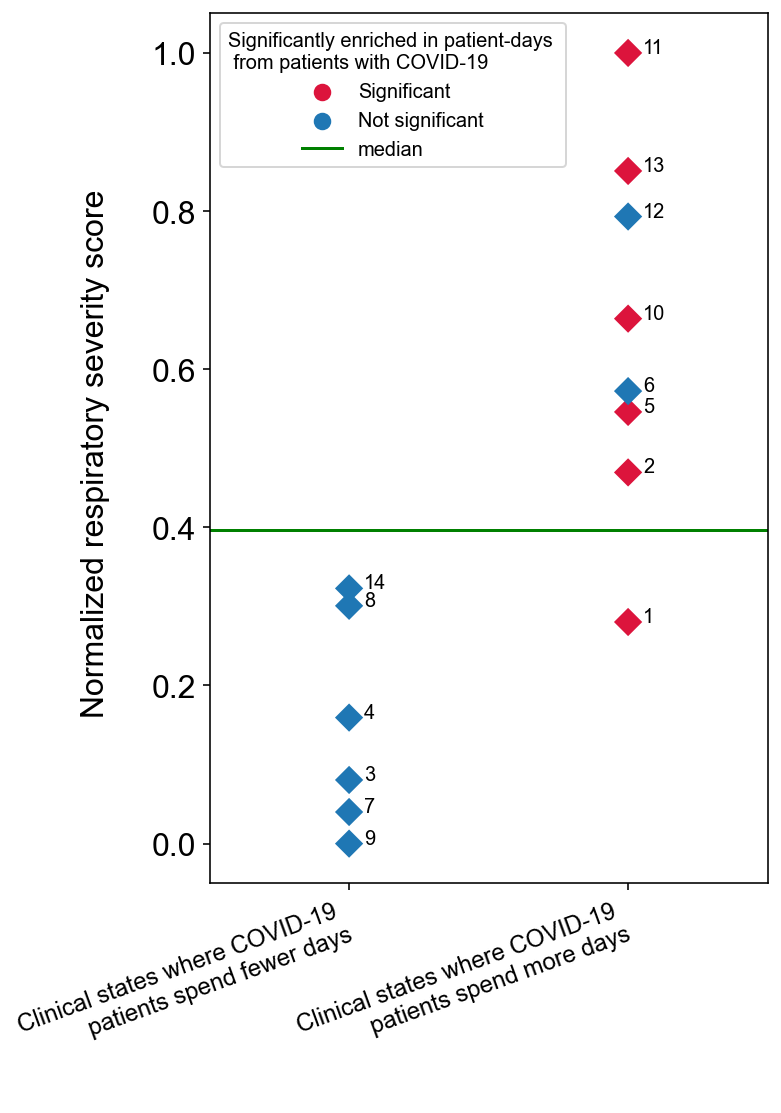

In [92]:
f,ax = plt.subplots(nrows=1,figsize=(5,8))

g=sns.stripplot(data=quiltdf2, x='COVID_higher', y='Respiratory', hue='COVID_stat_higher', palette=['crimson', 'tab:blue'],marker="D", size=10, jitter=False )
#g=sns.stripplot(data=quiltdf2, x='cluster',y='Respiratory',hue='COVID_stat_higher', palette=COVID_stat_higher_palette,)
g.axhline(y = quiltdf2.Respiratory.median(), color = "green", label='median')

for idx, row in quiltdf2.iterrows():
    ax.annotate(row['cluster'], (row['COVID_higher'], row['Respiratory']), xytext=(15, 0),textcoords="offset pixels",fontsize=10 )

ax.legend(title='Significantly enriched in patient-days \n from patients with COVID-19')
ax.set_xlabel(" ", size=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.set_xticklabels(['Clinical states where COVID-19 \n patients spend fewer days', 'Clinical states where COVID-19 \n patients spend more days'], size=12)
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.get_xticklabels():
    t.set_rotation(20)
    t.set_horizontalalignment("right")
    t.set_transform(t.get_transform() + trans)
ax.set_ylabel("Normalized respiratory severity score \n", size=16)
            
dump_figure('resp_score_covid_higher_sidebyside.pdf')

# relative resp score

In [ ]:
quiltdf3=quiltdf2.T

In [23]:
quiltdf3

1         2         3         4         5   \
Neurologic              0.623961  0.192728  0.404519  0.000000  0.869719   
Respiratory             0.280297  0.469480  0.080514  0.159394  0.545973   
Shock                   0.160465  0.163009  0.068582  0.000000  0.604149   
Renal                   0.206030  0.268305  0.305147  0.297252  0.257720   
Inflammatory            0.597210  0.597577  0.279115  0.295680  0.577480   
Ventilator instability  0.993319  0.322708  0.618315  0.563630  1.000000   

                              6         7         8         9         10  \
Neurologic              0.652211  0.625247  0.306584  0.037408  0.971435   
Respiratory             0.572323  0.039998  0.300761  0.000000  0.663961   
Shock                   0.491165  0.751093  0.290522  0.779541  0.988186   
Renal                   0.093763  0.538306  0.252896  0.506906  0.597616   
Inflammatory            0.798126  0.714811  0.217167  0.546477  1.000000   
Ventilator instability  0.432941  0.526851  0.682485  0.000000  0.947825   

                              11        12        13        14  
Neurologic              0.731059  0.179159  1.000000  0.624259  
Respiratory             1.000000  0.793091  0.850739  0.322798  
Shock                   0.679276  0.340747  0.827239  1.000000  
Renal                   0.238880  0.000000  0.110575  1.000000  
Inflammatory            0.722400  0.000000  0.923872  0.681939  
Ventilator instability  0.526173  0.672842  0.737806  0.657188

In [24]:
dump_table(quiltdf3, 'quiltdf3_normalized.csv')

In [7]:
quiltdf3 = pd.read_csv(
    inout.get_material_path('CAG/04_clustering_spider/quiltdf3_normalized_221201_1331.csv'), 
    index_col=0)

In [9]:
quiltdf3=quiltdf3.T

In [18]:
quiltdf3=quiltdf3.reset_index()

<AxesSubplot:xlabel='index', ylabel='Relative Resp Severity'>

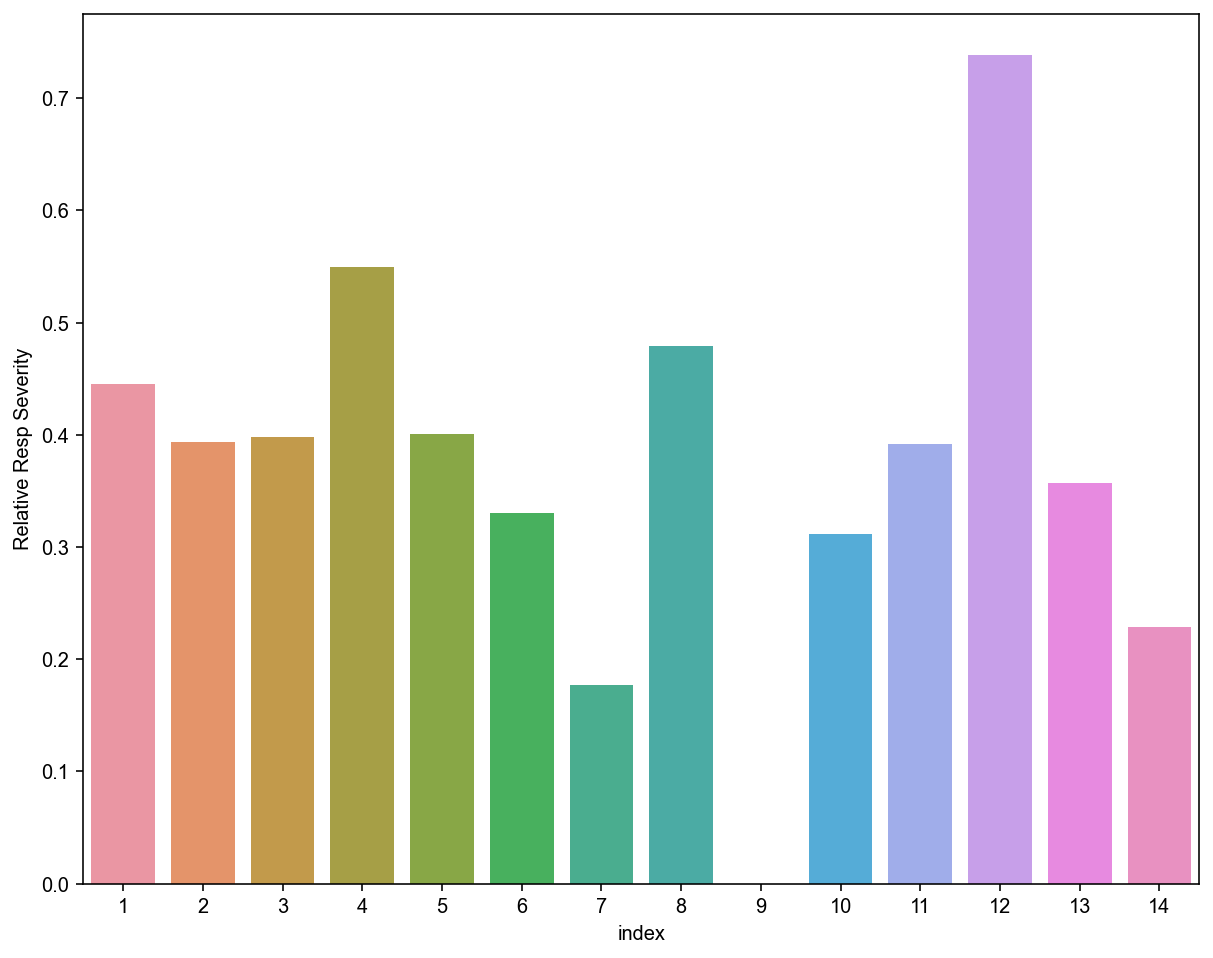

In [19]:
quiltdf3['Relative Resp Severity'] = (quiltdf3['Respiratory']+quiltdf3['Ventilator instability'])/(quiltdf3['Respiratory']+quiltdf3['Ventilator instability']+quiltdf3['Neurologic']+quiltdf3['Shock']+quiltdf3['Renal']+quiltdf3['Inflammatory'])

sns.barplot(data=quiltdf3, x='index', y='Relative Resp Severity')

<AxesSubplot:xlabel='index', ylabel='Respiratory'>

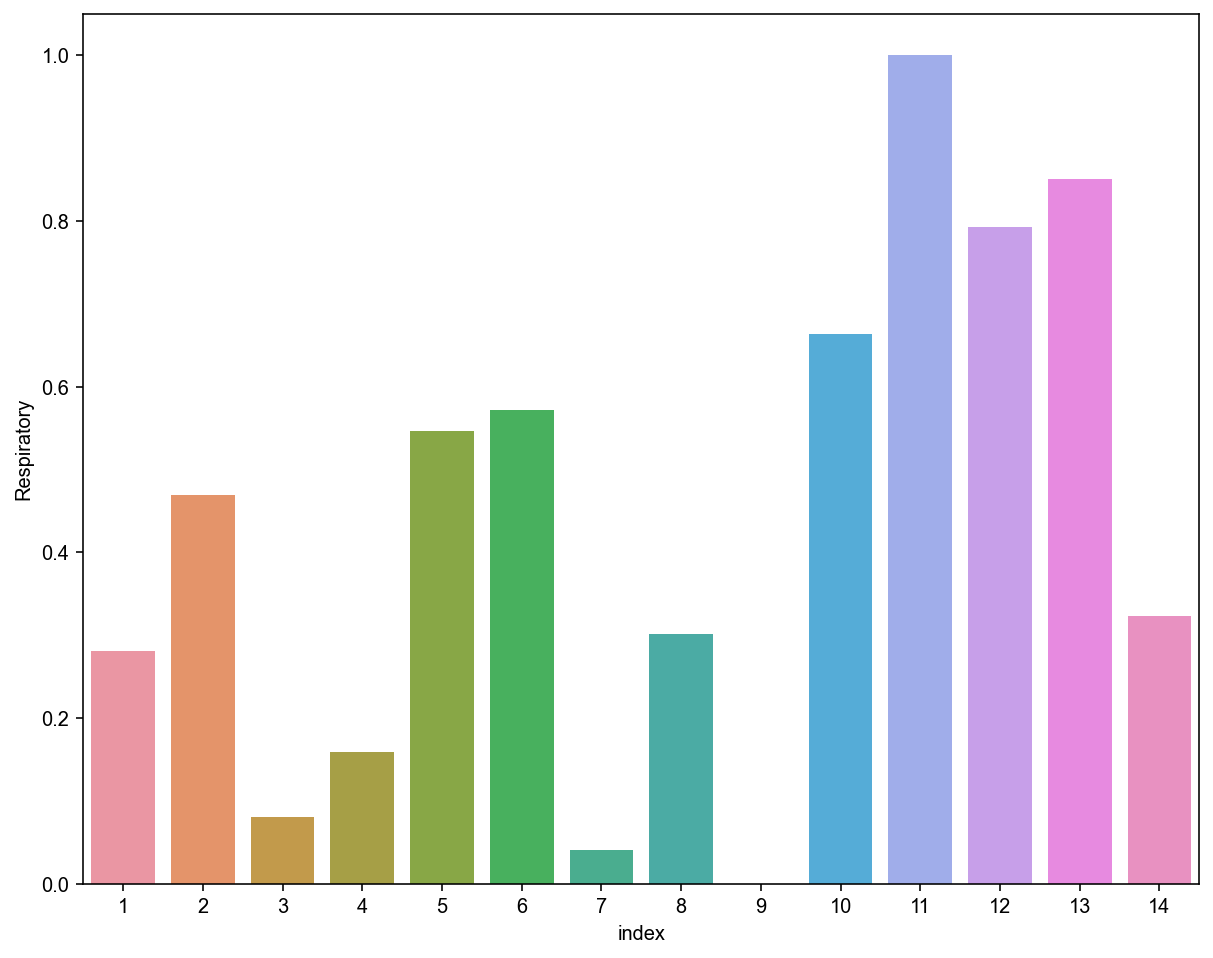

In [23]:
sns.barplot(data=quiltdf3, x='index', y='Respiratory')

<AxesSubplot:xlabel='index', ylabel='Relative Resp Severity'>

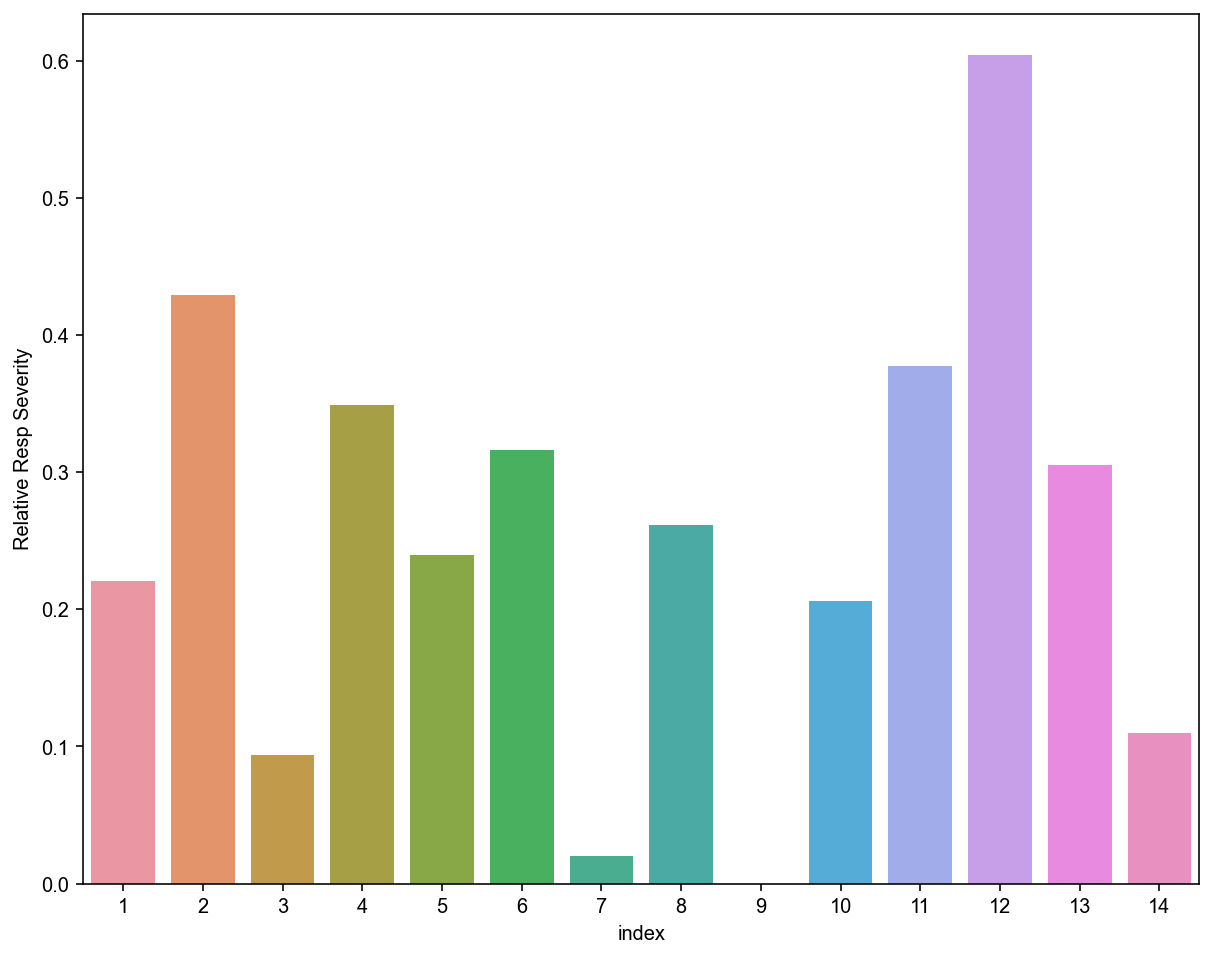

In [29]:
quiltdf3['Relative Resp Severity'] = (quiltdf3['Respiratory'])/(quiltdf3['Respiratory']+quiltdf3['Neurologic']+quiltdf3['Shock']+quiltdf3['Renal'])

sns.barplot(data=quiltdf3, x='index', y='Relative Resp Severity')

# graph spiders plotly

In [1]:
import plotly.express as px

In [ ]:
# example from: https://plotly.com/python/radar-chart/
df = pd.DataFrame(dict(
    r=[1, 5, 2, 2, 3],
    theta=['processing cost','mechanical properties','chemical stability',
           'thermal stability', 'device integration']))
fig = px.line_polar(df, r='r', theta='theta', line_close=True)
fig.update_traces(fill='toself')
fig.show()

/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



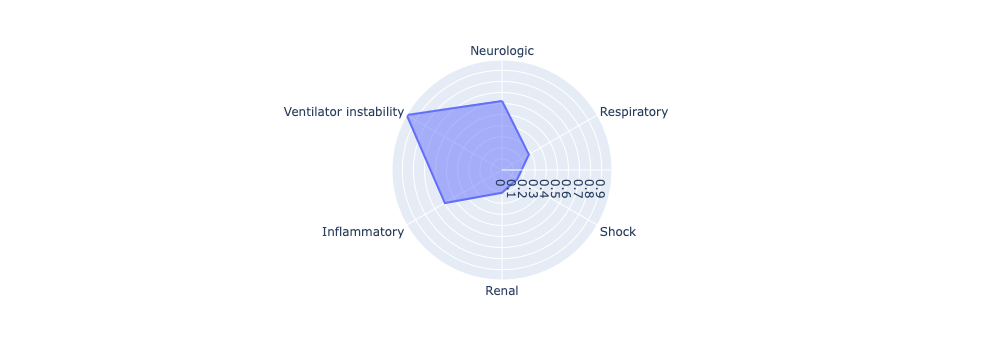

In [24]:
df = pd.DataFrame(quiltdf3.loc[:, ['1']].reset_index().rename(columns={"index": "theta", '1': "r"}).to_dict('list'))
fig = px.line_polar(df, r='r', theta='theta', line_close=True)
fig.update_traces(fill='toself')
fig.show()
fig.write_image("spider1.pdf", engine="kaleido")

/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



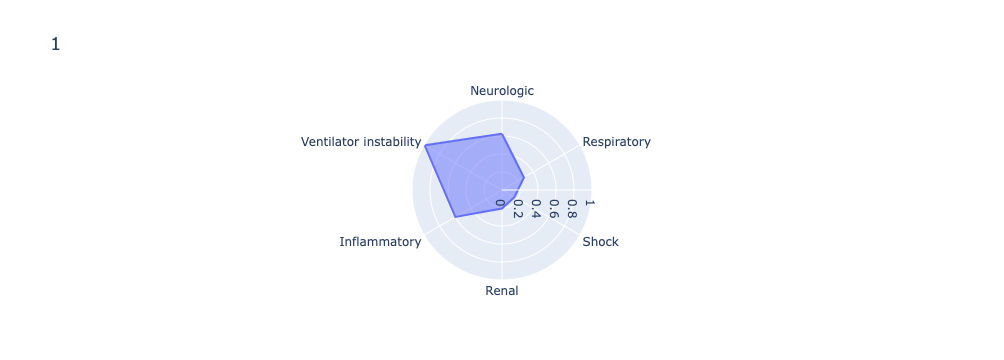

/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



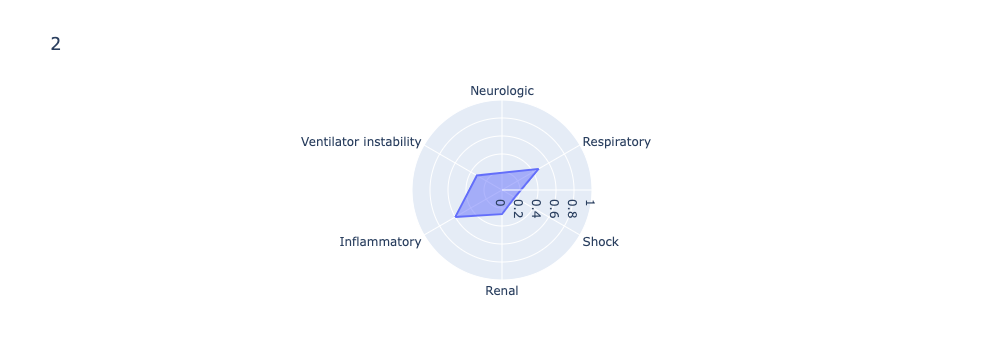

/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



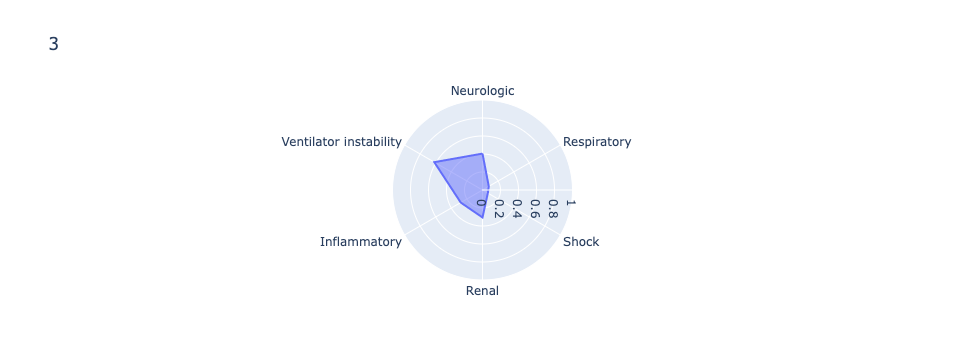

/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



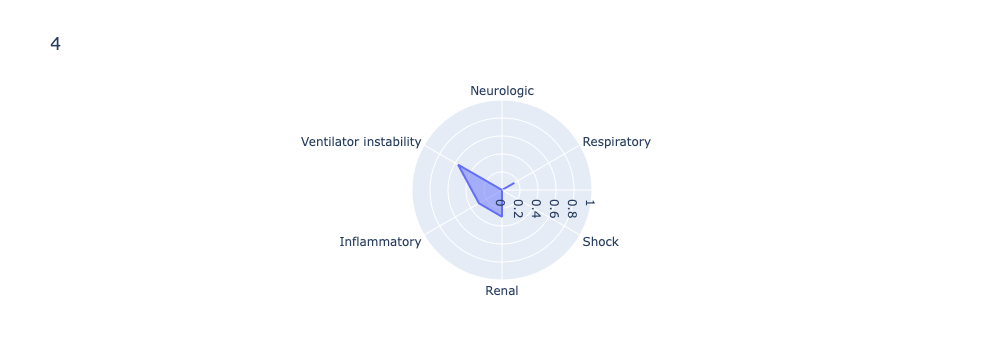

/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



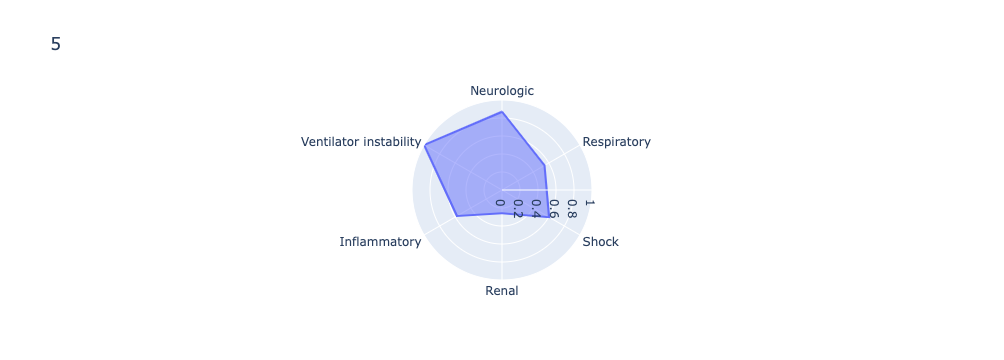

/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



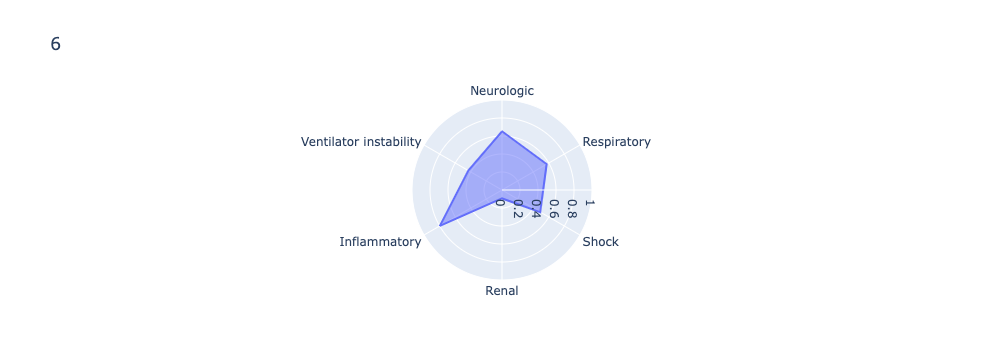

/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



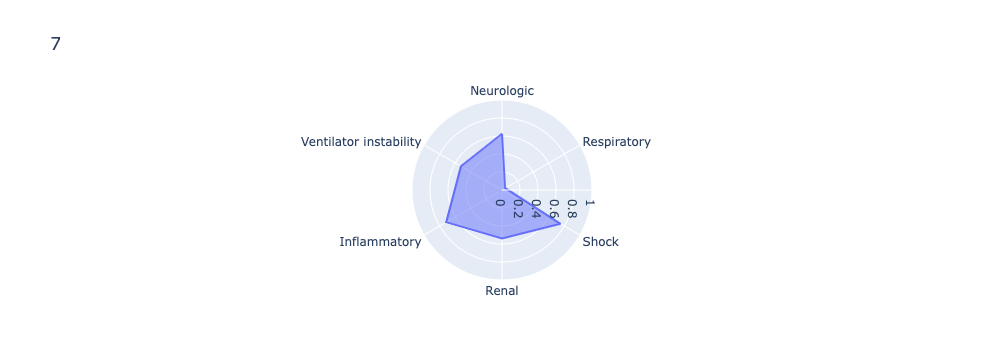

/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



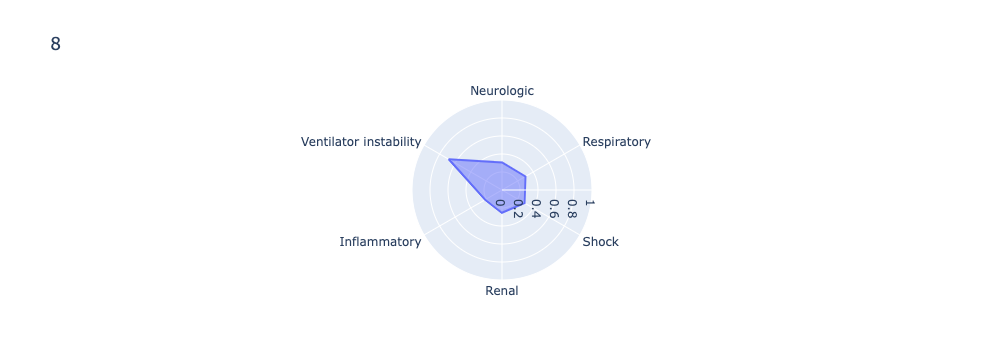

/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



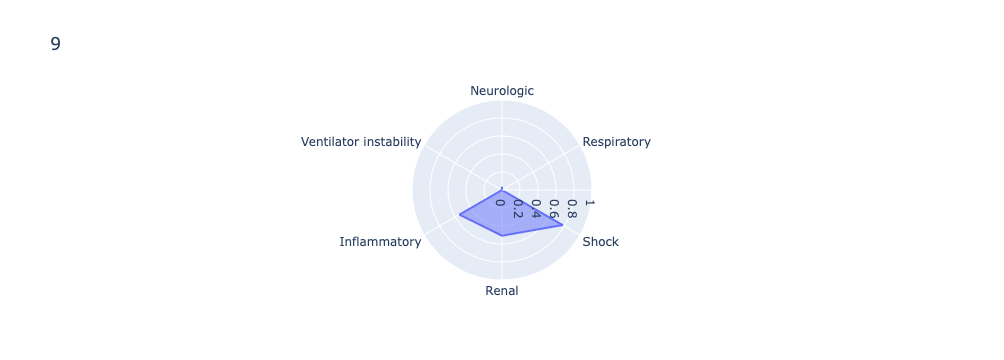

/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



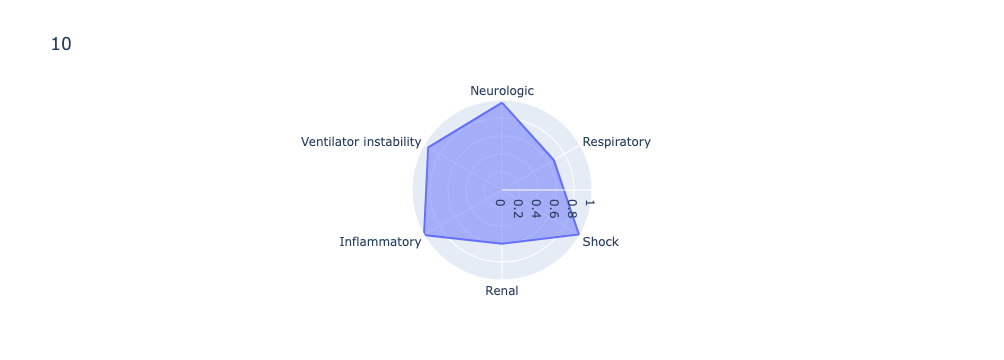

/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



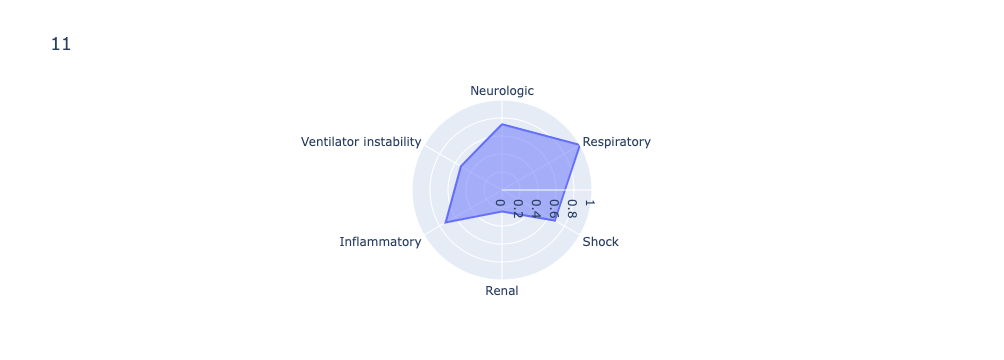

/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



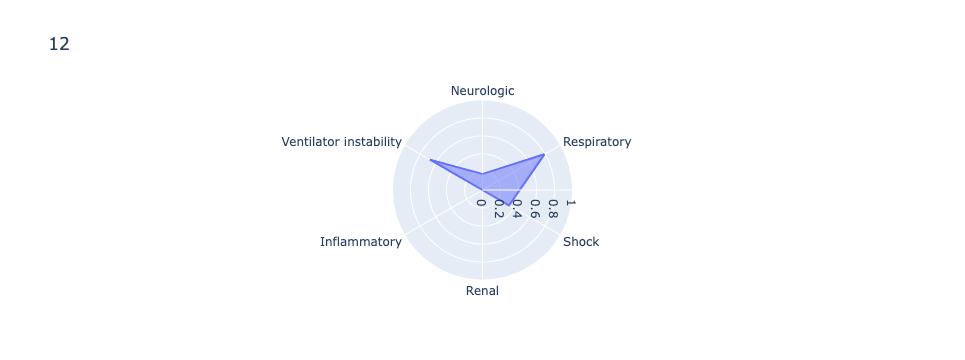

/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



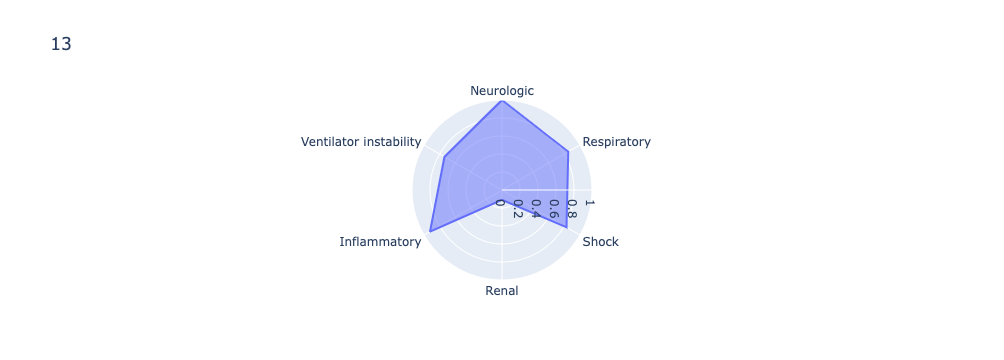

/Users/cag895/opt/anaconda3/lib/python3.8/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



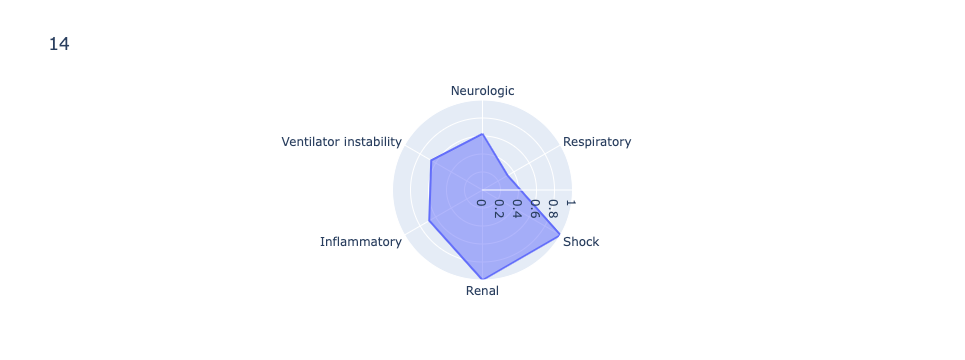

In [25]:
for col in quiltdf3.columns:
    df = quiltdf3.loc[:, [col]].reset_index().rename(columns={"index": "theta", col: "r"})
    fig = px.line_polar(df, r='r', theta='theta', line_close=True, range_r=[0,1], title=col)
    fig.update_traces(fill='toself')
    fig.show()
    fig.write_image(f"spider{col}.pdf", engine="kaleido")

# spiders using matplotlib 

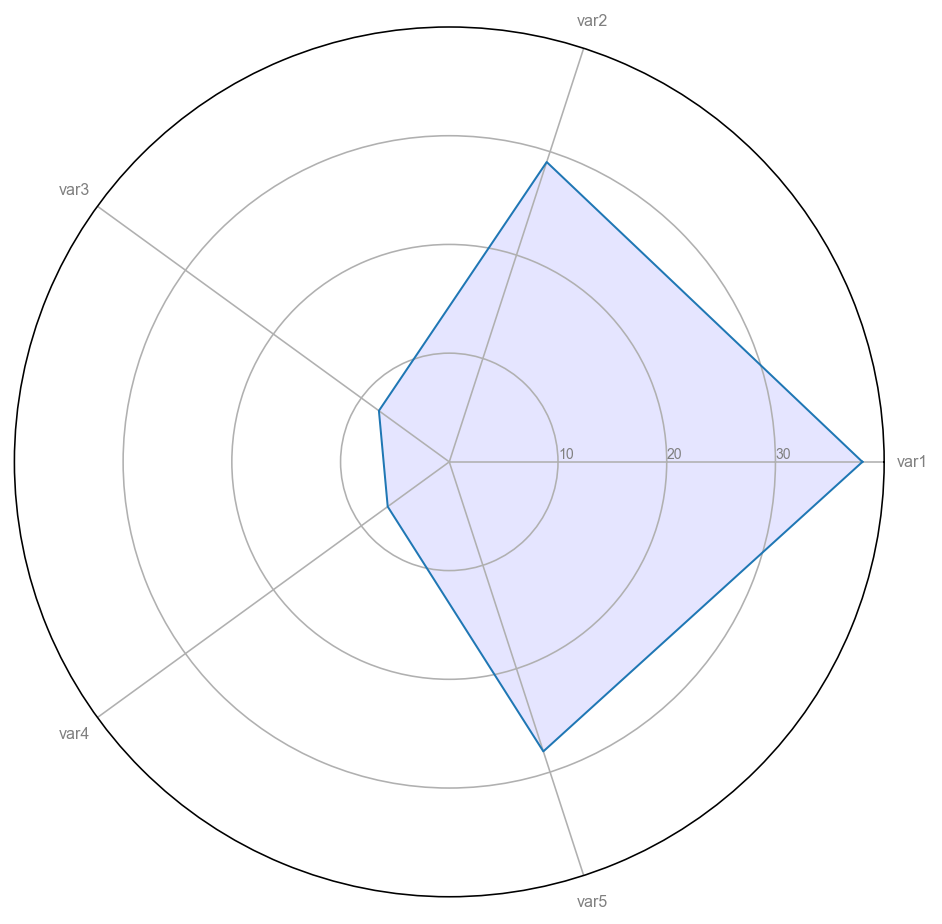

In [30]:
#example https://www.python-graph-gallery.com/390-basic-radar-chart 

# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
plt.ylim(0,40)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)

# Show the graph
plt.show()

In [106]:
df = pd.read_csv(
    inout.get_material_path('CAG/04_clustering_spider/quiltdf3_normalized_221201_1331.csv'), 
    index_col=0)


In [112]:
from math import pi

In [107]:
df=df.T.reset_index()

In [108]:
df = df[["index", "Respiratory", "Shock", "Neurologic", "Renal", "Inflammatory", "Ventilator instability"]] 

In [109]:
# number of variable
categories=list(df)[1:]
N = len(categories)
categories

['Respiratory',
 'Shock',
 'Neurologic',
 'Renal',
 'Inflammatory',
 'Ventilator instability']

In [110]:
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.loc[0].drop('index').values.flatten().tolist()
values += values[:1]
values

[0.2802974705996297,
 0.1604648930193432,
 0.6239609222942585,
 0.2060301964666678,
 0.5972104444928228,
 0.9933185059070648,
 0.2802974705996297]

In [113]:
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi + pi / 2 for n in range(N)]
angles += angles[:1]
angles

[1.5707963267948966,
 2.617993877991494,
 3.665191429188092,
 4.71238898038469,
 5.759586531581287,
 6.806784082777885,
 1.5707963267948966]

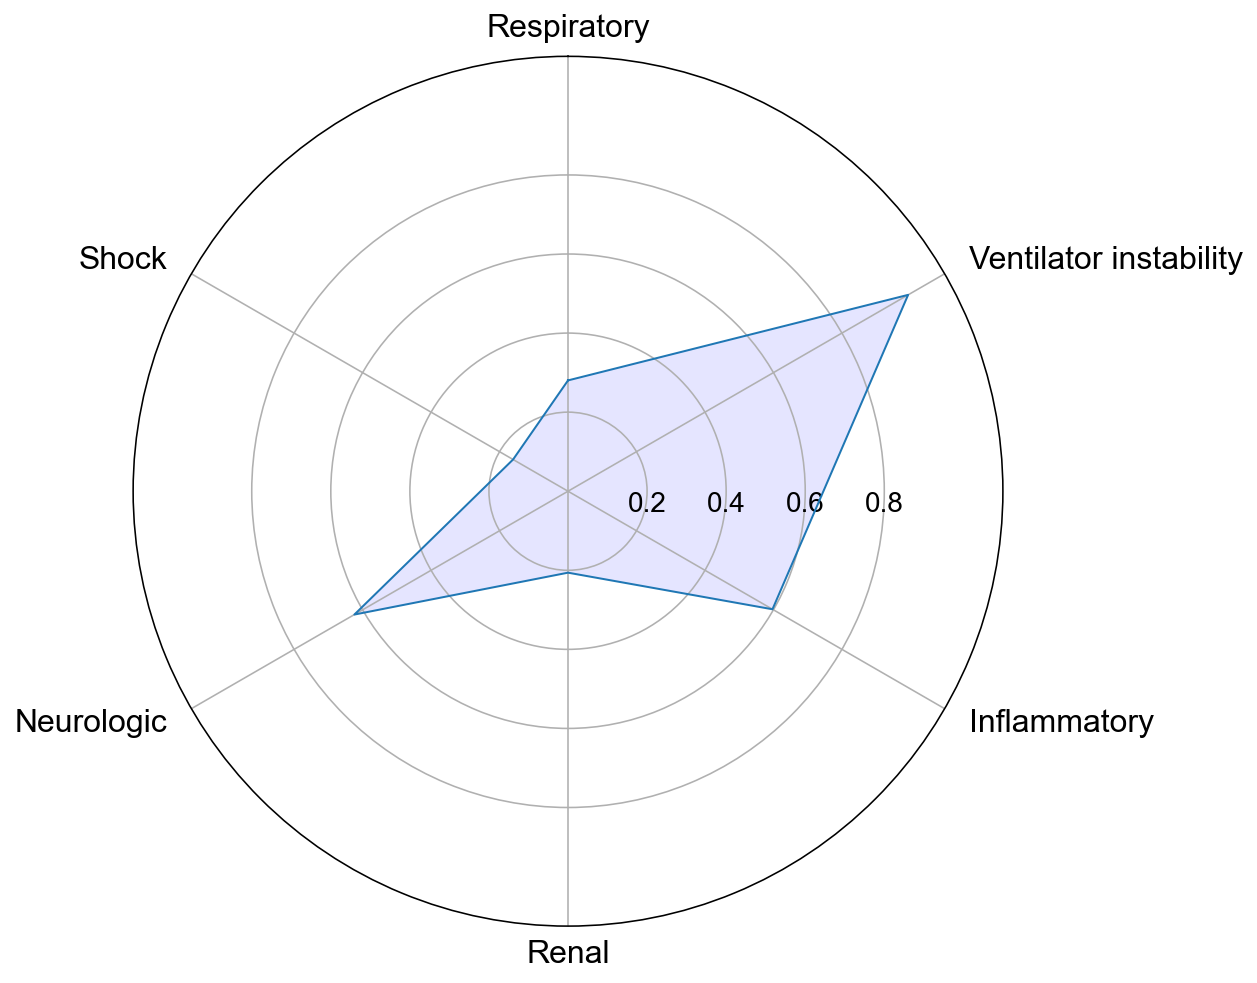

In [114]:
# Initialise the spider plot
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='black', size=16)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([.2,.4,.6,.8], ["0.2","0.4","0.6","0.8"], color="black", size=14)
plt.ylim(0,1.1)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)

ax.set_facecolor('white')
ax.set_thetalim(np.pi / 2, np.pi / 2 + 2 * np.pi)

for t in ax.get_xticklabels():
    theta = t.get_position()[0]
    if theta > np.pi / 2 and theta < 3 * np.pi / 2:
        t.set_horizontalalignment("right")
    if theta > 3 * np.pi / 2:
        t.set_horizontalalignment("left")

# Show the graph
plt.show()

ax.figure.savefig('spider.pdf')

In [144]:
df=df.T.reset_index()

In [148]:
df

index  Neurologic  Respiratory     Shock     Renal  Inflammatory  \
0      1    0.623961     0.280297  0.160465  0.206030      0.597210   
1      2    0.192728     0.469480  0.163009  0.268305      0.597577   
2      3    0.404519     0.080514  0.068582  0.305147      0.279115   
3      4    0.000000     0.159394  0.000000  0.297252      0.295680   
4      5    0.869719     0.545973  0.604149  0.257720      0.577480   
5      6    0.652211     0.572323  0.491165  0.093763      0.798126   
6      7    0.625247     0.039998  0.751093  0.538306      0.714811   
7      8    0.306584     0.300761  0.290522  0.252896      0.217167   
8      9    0.037408     0.000000  0.779541  0.506906      0.546477   
9     10    0.971435     0.663961  0.988186  0.597616      1.000000   
10    11    0.731059     1.000000  0.679276  0.238880      0.722400   
11    12    0.179159     0.793091  0.340747  0.000000      0.000000   
12    13    1.000000     0.850739  0.827239  0.110575      0.923872   
13    14    0.624259     0.322798  1.000000  1.000000      0.681939   

    Ventilator instability  
0                 0.993319  
1                 0.322708  
2                 0.618315  
3                 0.563630  
4                 1.000000  
5                 0.432941  
6                 0.526851  
7                 0.682485  
8                 0.000000  
9                 0.947825  
10                0.526173  
11                0.672842  
12                0.737806  
13                0.657188

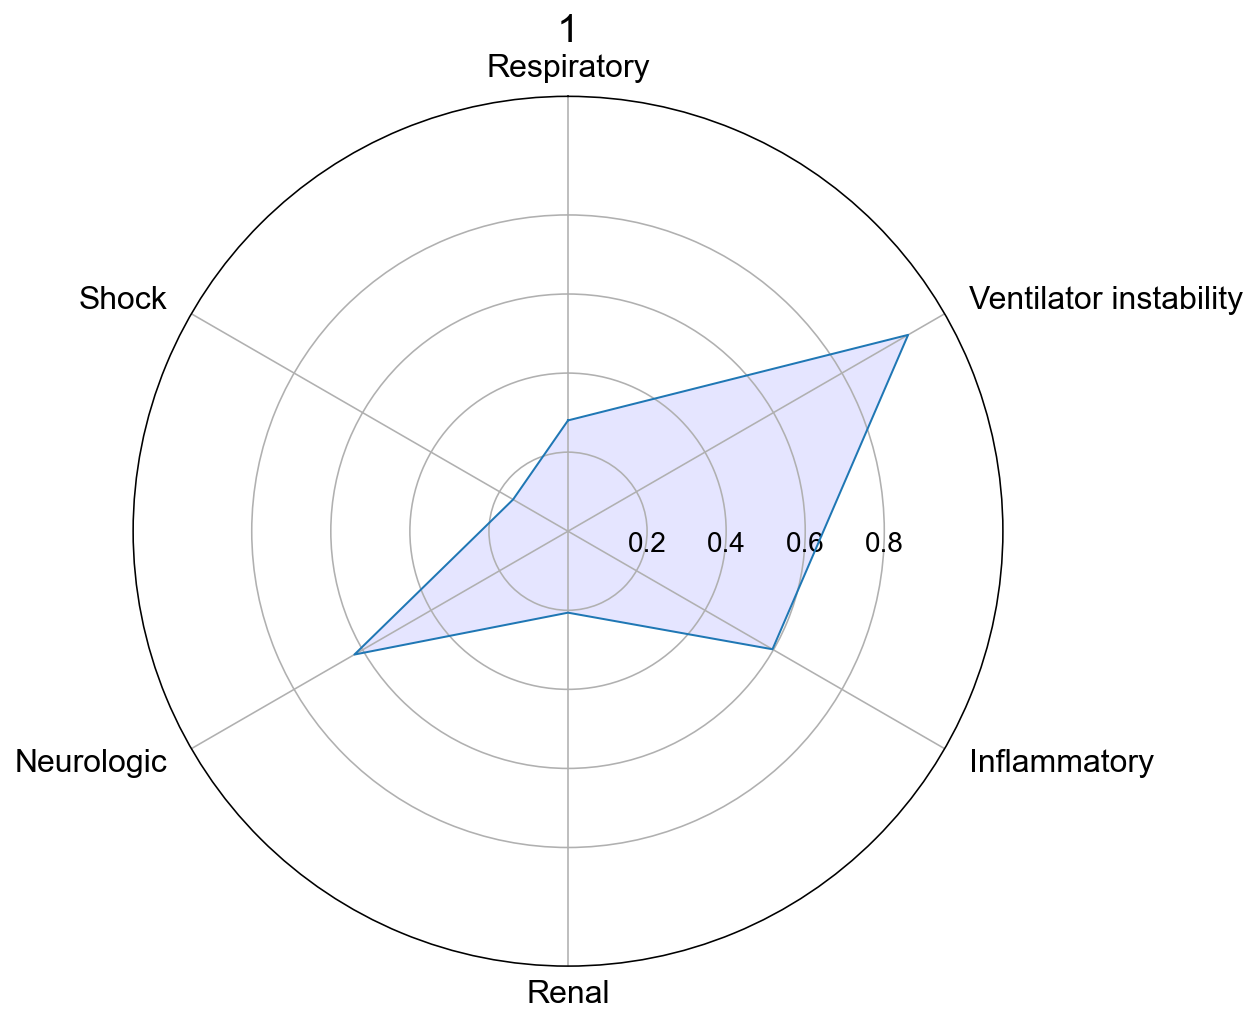

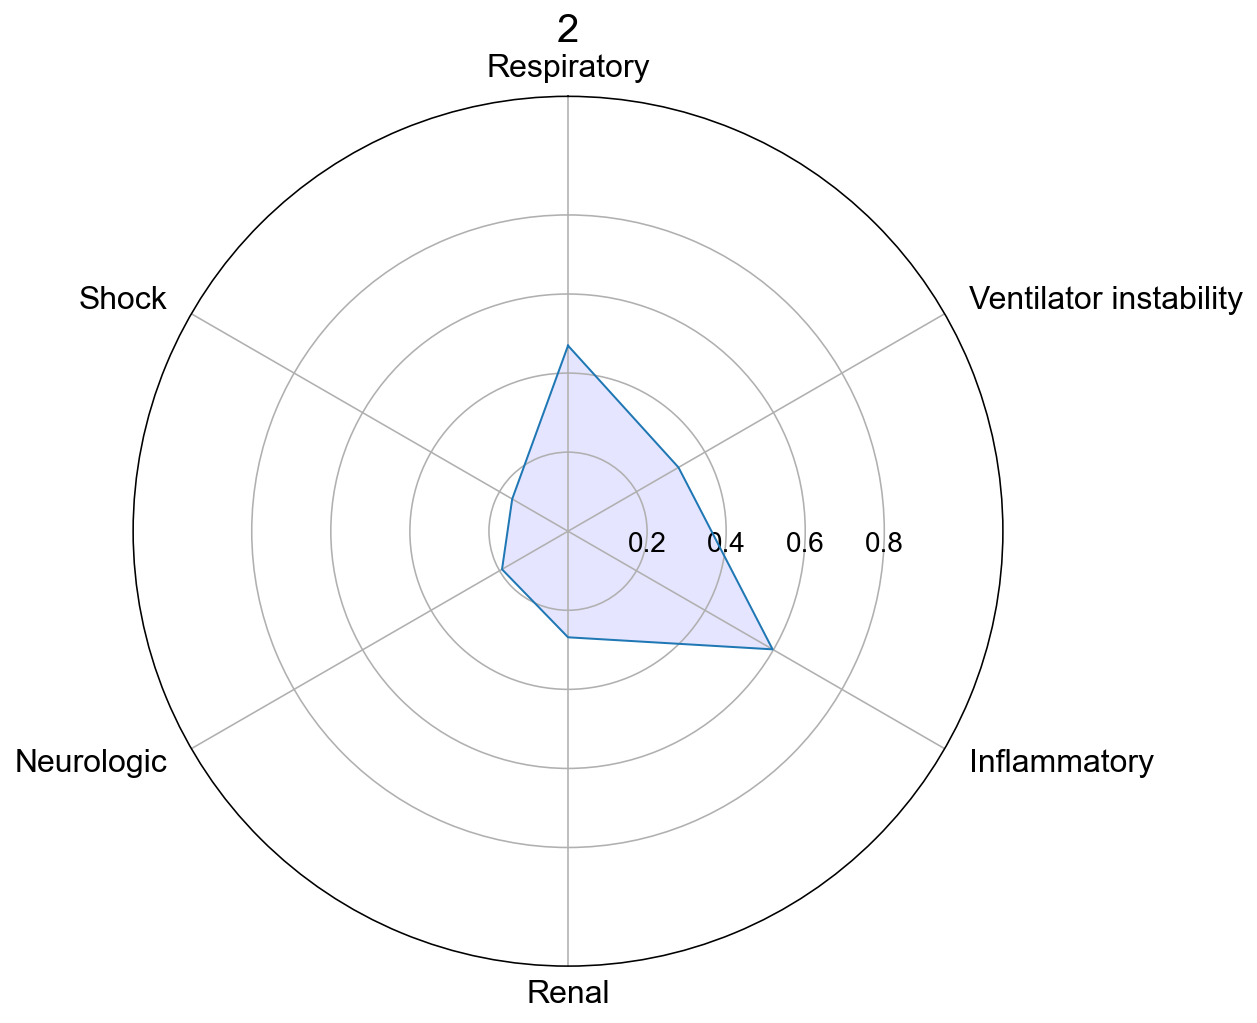

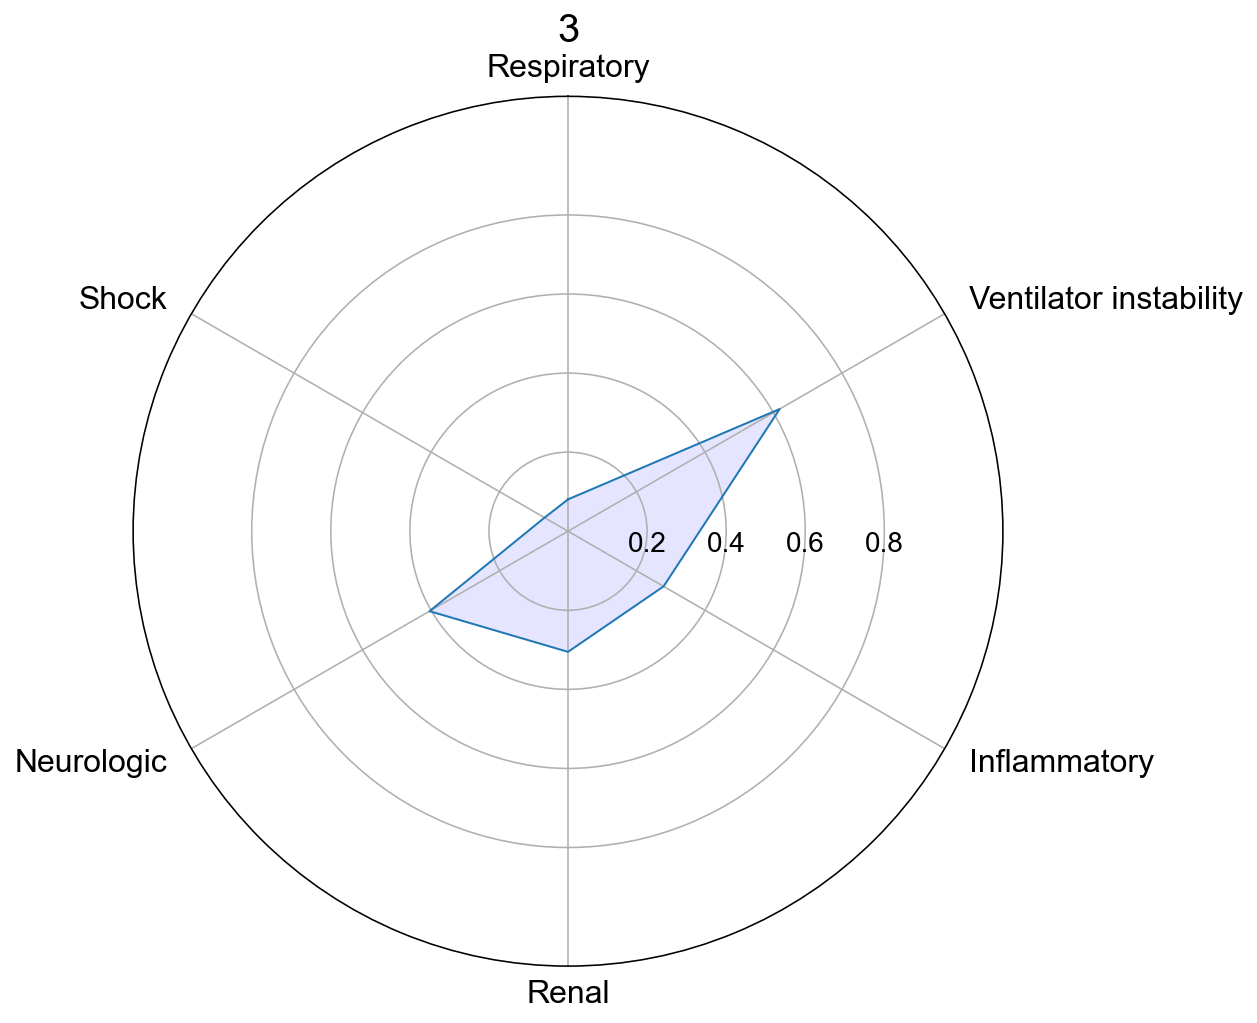

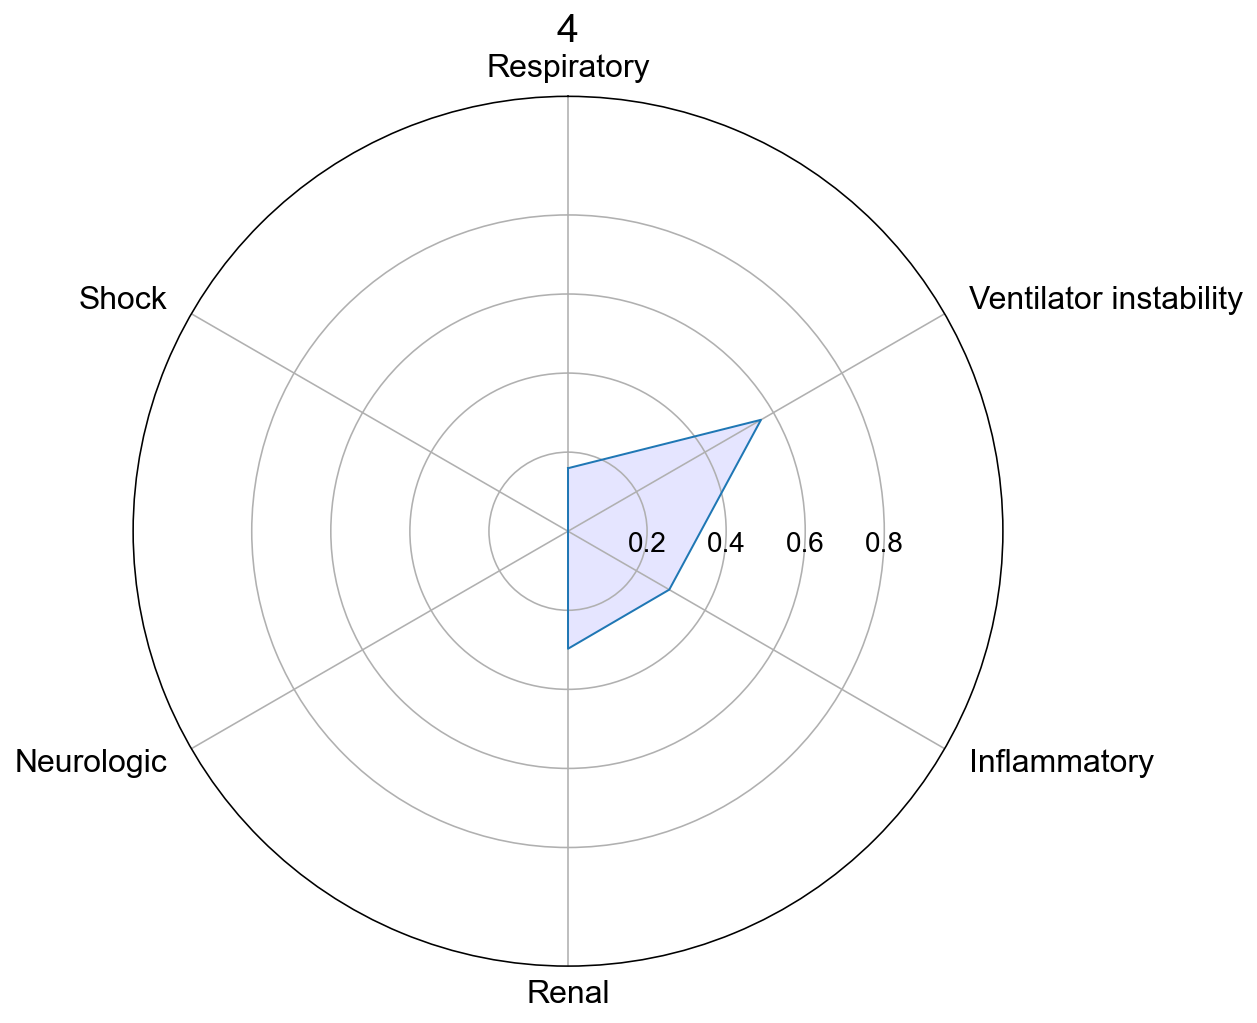

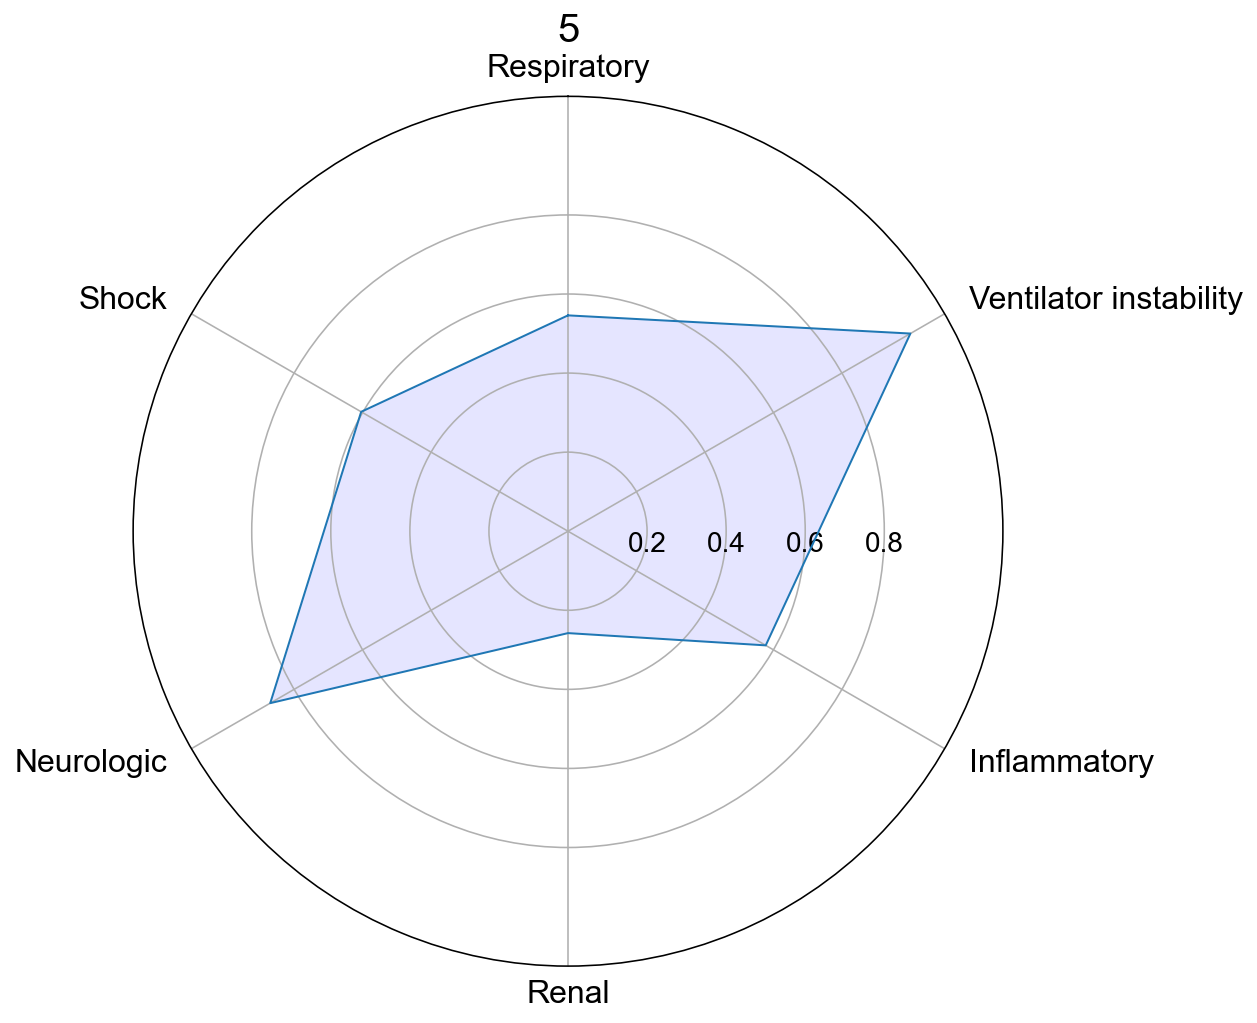

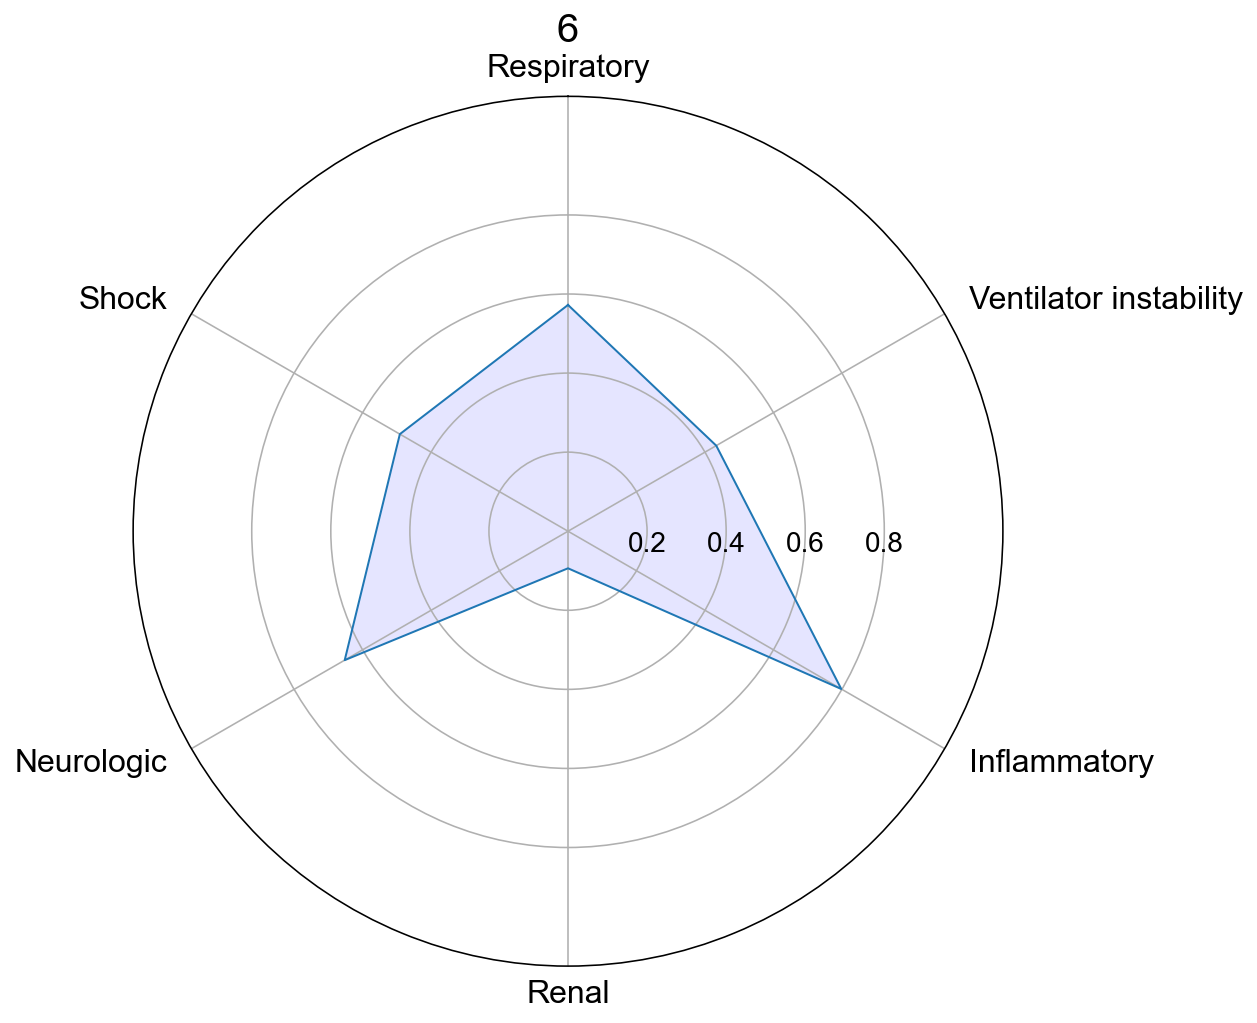

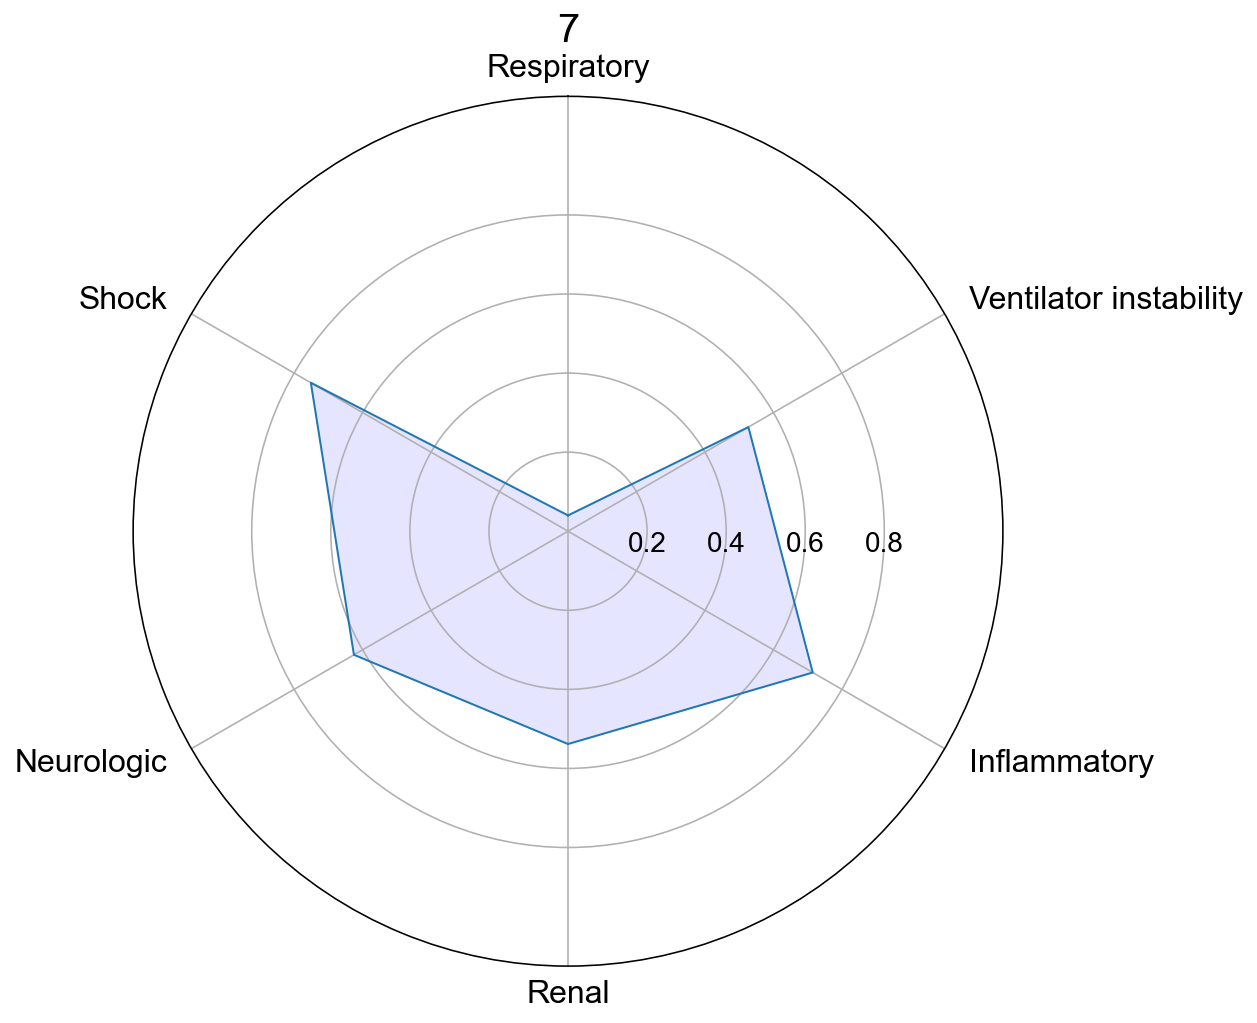

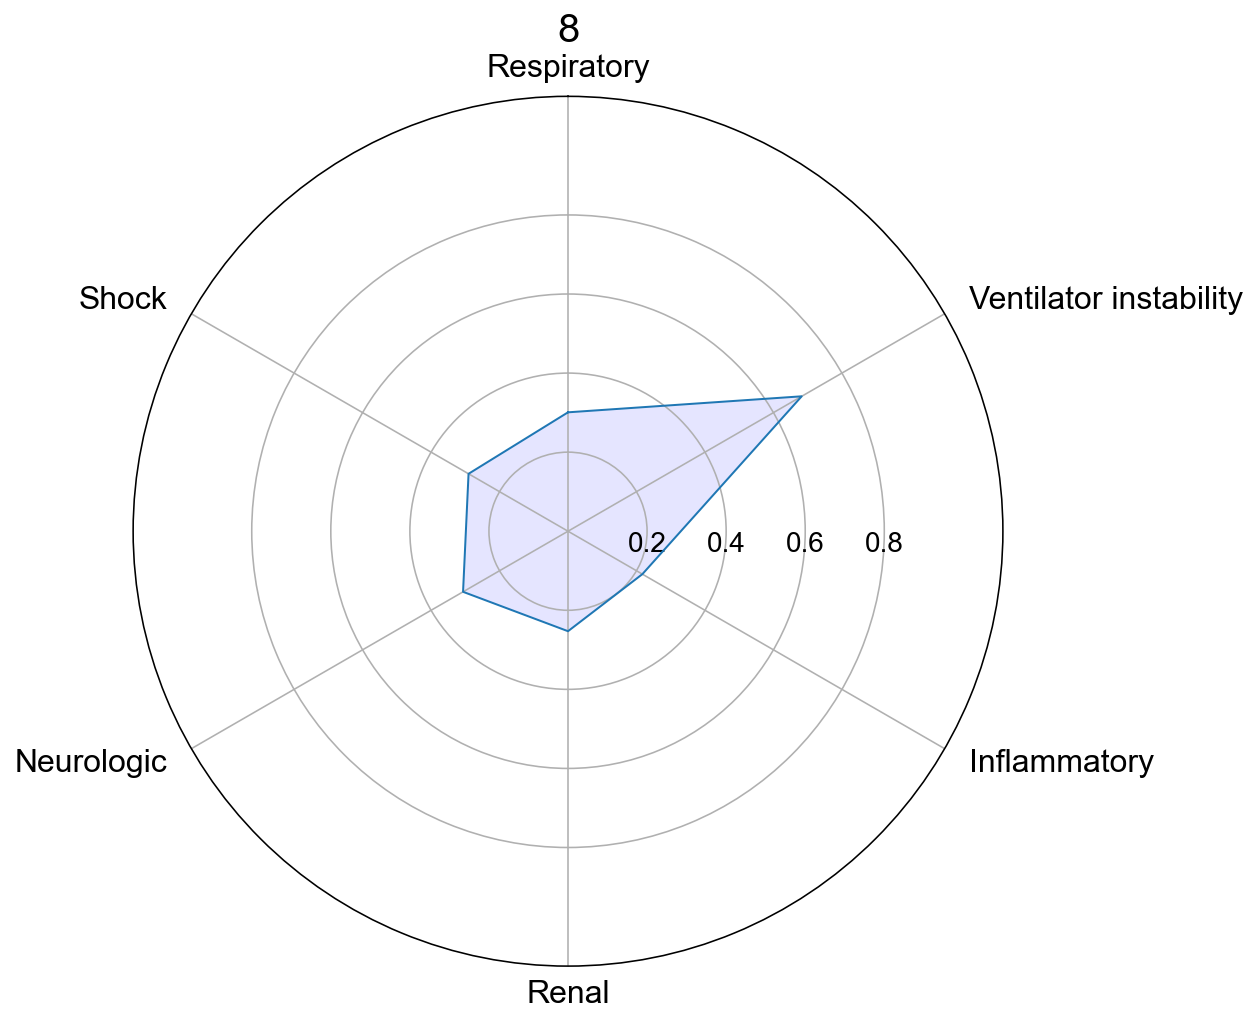

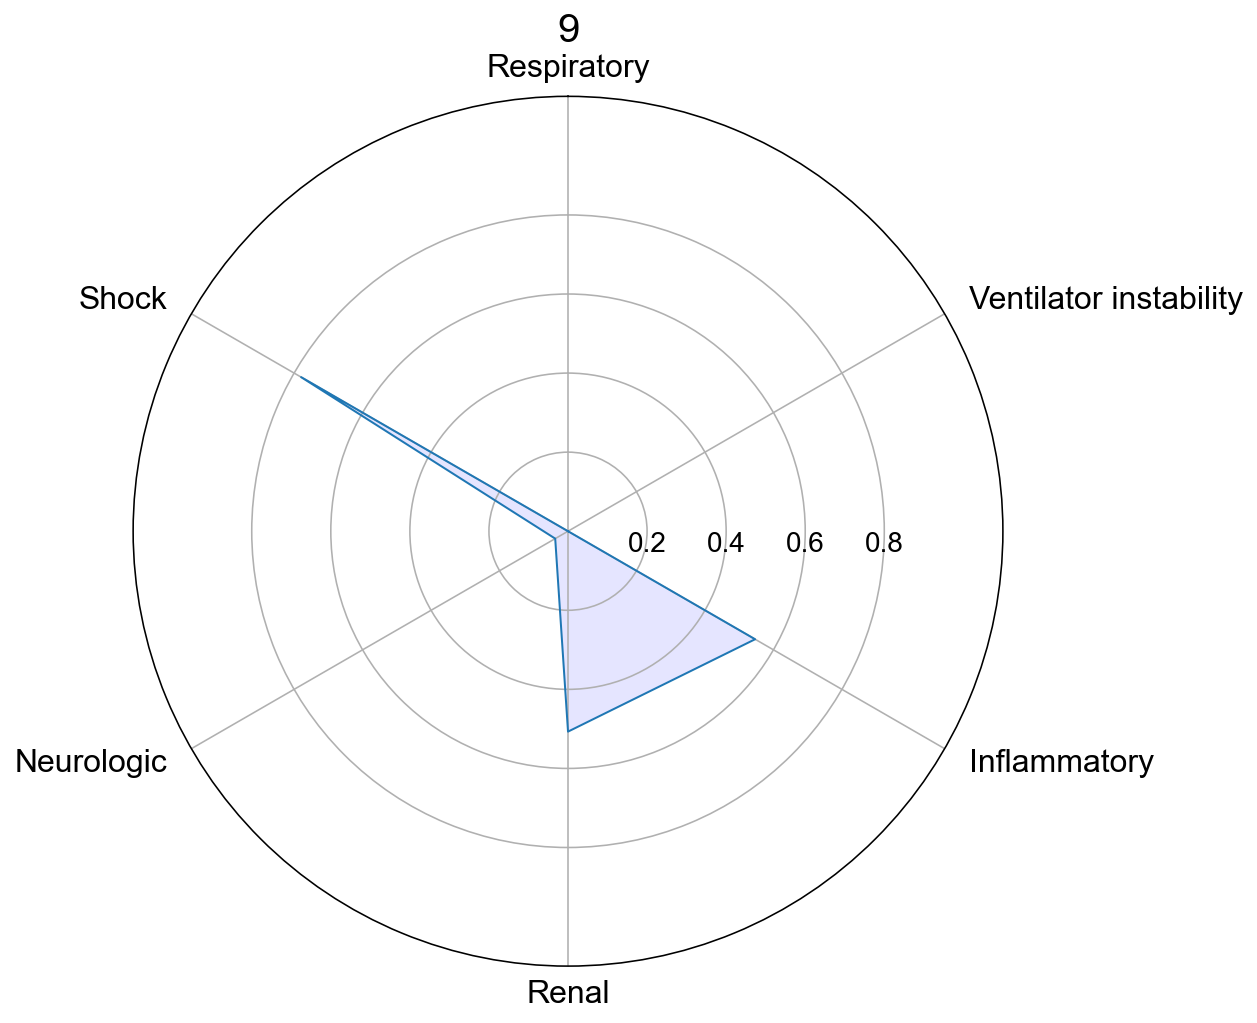

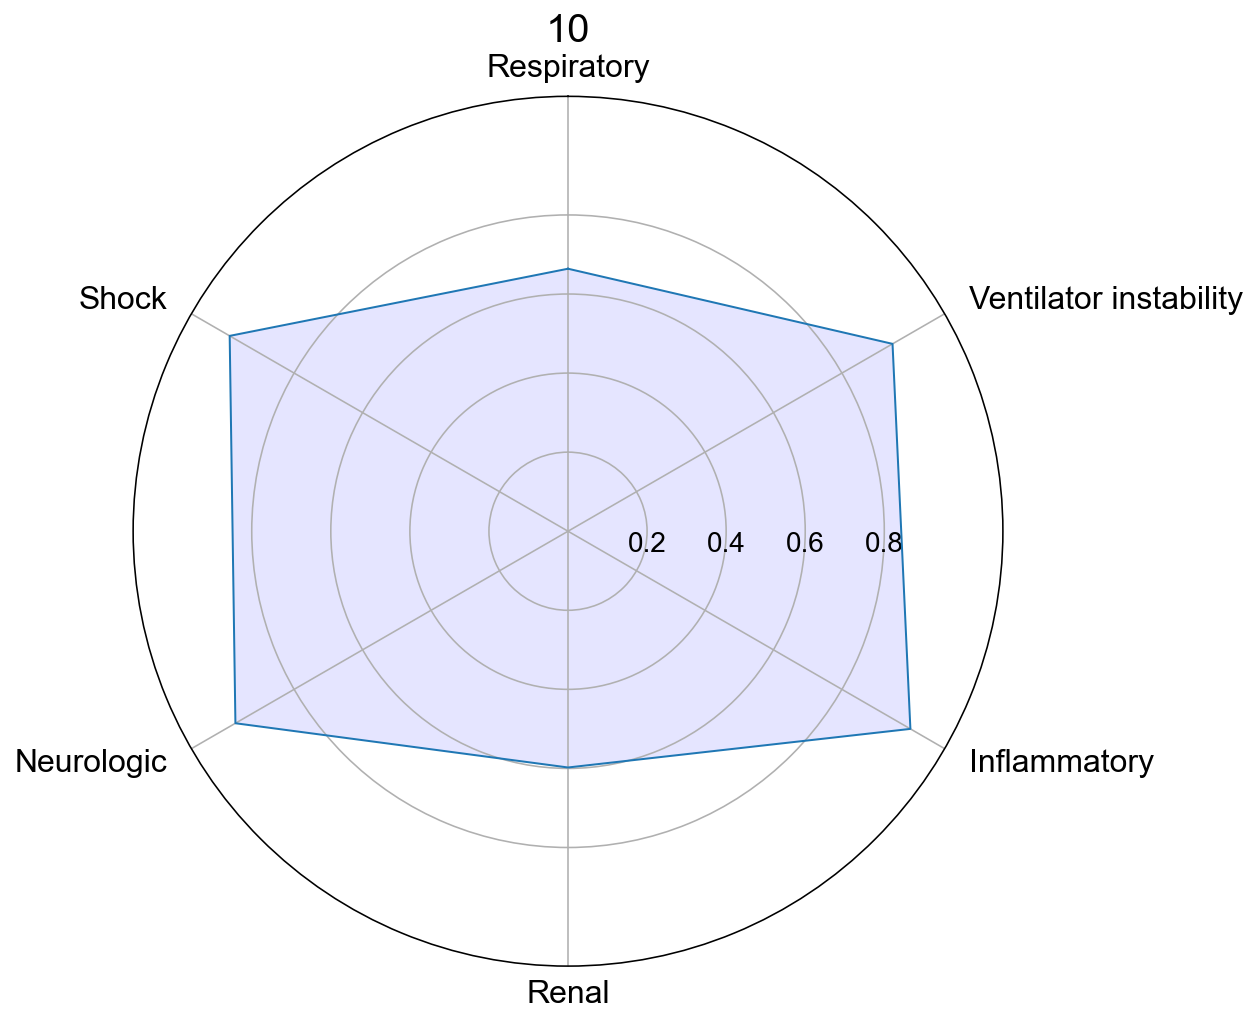

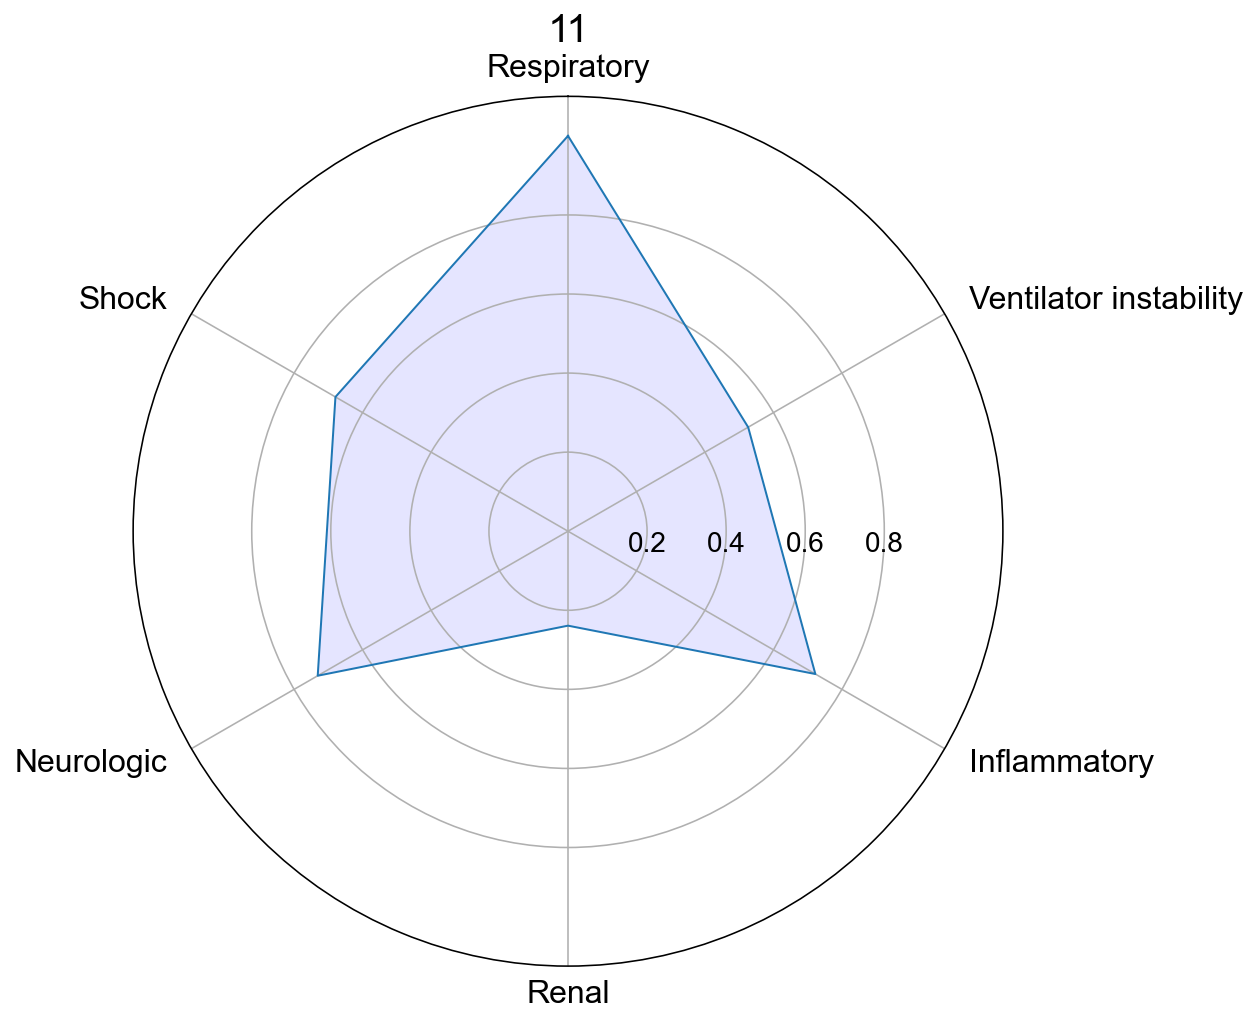

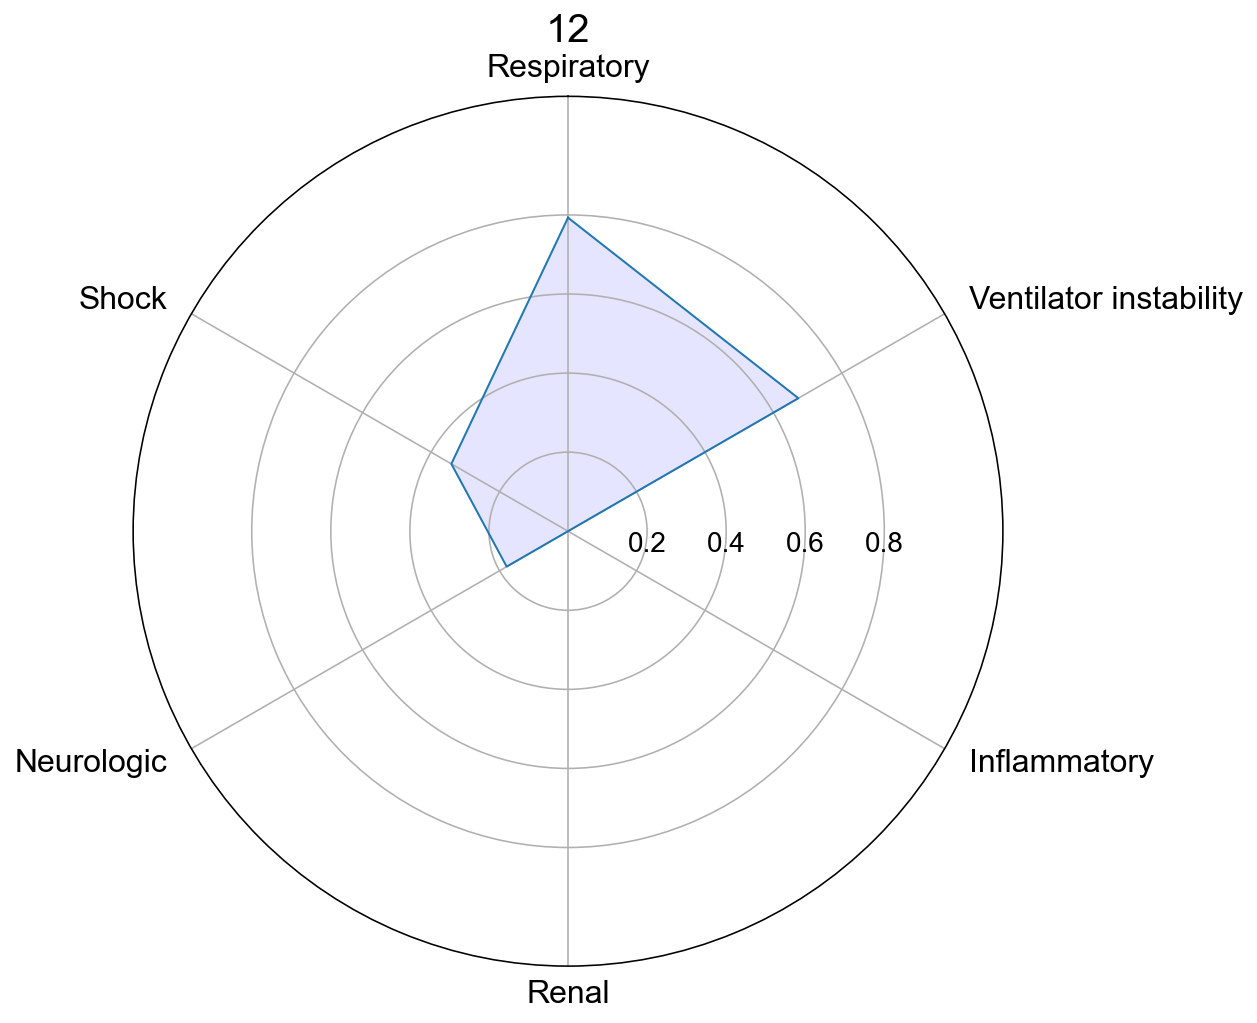

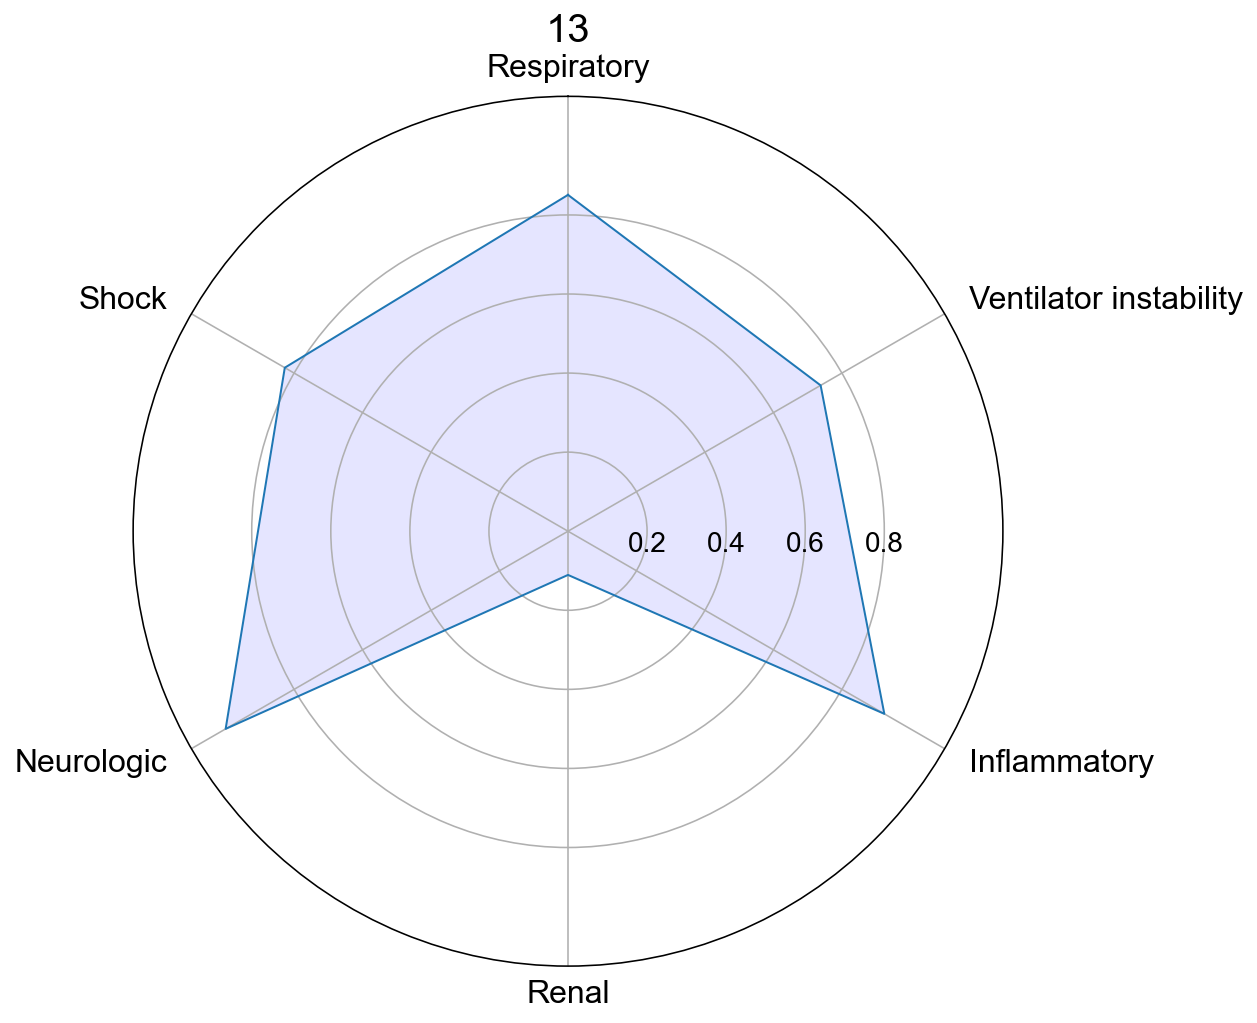

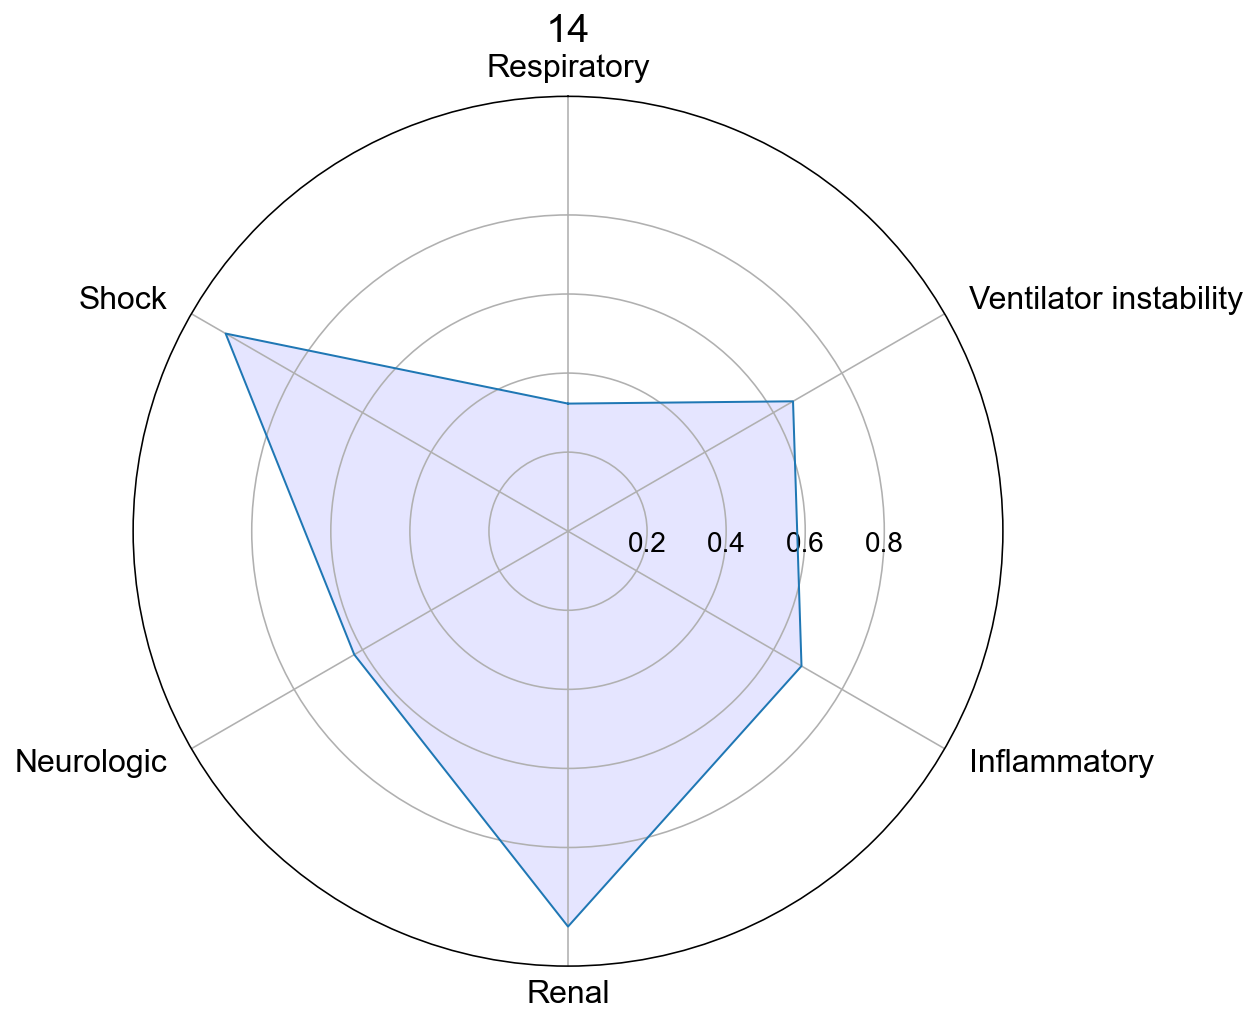

In [115]:
for row, row_data in df.iterrows():
    state = row_data["index"]
    
    categories=list(df)[1:]
    N = len(categories)

    values=df.loc[row].drop('index').values.flatten().tolist()
    values += values[:1]

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi + pi / 2 for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    fig, ax = plt.subplots(subplot_kw={"projection": "polar"})

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories, color='black', size=16)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([.2,.4,.6,.8], ["0.2","0.4","0.6","0.8"], color="black", size=14)
    plt.ylim(0,1.1)

    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

    ax.set_facecolor('white')
    ax.set_thetalim(np.pi / 2, np.pi / 2 + 2 * np.pi)

    ax.set_title(f'{state}')
    ax.title.set_size(20)
    
    for t in ax.get_xticklabels():
        theta = t.get_position()[0]
        if theta > np.pi / 2 and theta < 3 * np.pi / 2:
            t.set_horizontalalignment("right")
        if theta > 3 * np.pi / 2:
            t.set_horizontalalignment("left")

    # Show the graph
    plt.show()

    ax.figure.savefig(f'spider{state}.pdf')

In [ ]:
val = [0.5] * 6
k = [np.pi / 2 + np.pi * 2 * x / len(val) for x in range(len(val))]

fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.plot(k + k[:1], val + val[:1])
ax.fill(k + k[:1], val + val[:1], alpha=0.2)
ax.set_xticks(k)
ax.set_xticklabels([f"Label {x}" for x in range(len(val))])
ax.set_thetalim(np.pi / 2, np.pi / 2 + 2 * np.pi)
ax.set_rlabel_position(0)
ax.set_rlim(top=1)
for t in ax.get_xticklabels():
    theta = t.get_position()[0]
    if theta > np.pi / 2 and theta < 3 * np.pi / 2:
        t.set_horizontalalignment("right")
    if theta > 3 * np.pi / 2:
        t.set_horizontalalignment("left")